In [1]:
import Pkg; Pkg.instantiate(); Pkg.activate()

  Activating project at `~/.julia/environments/v1.10`


In [2]:
using RxInfer
using Distributions
using Random
using GraphPlot
using Graphs
using MetaGraphsNext
using GraphPPL
using GraphViz
using Dictionaries
using Plots
using StableRNGs
using LinearAlgebra
using StatsPlots
using LaTeXStrings
using DataFrames
using CSV
using GLM

using Cairo # necessary for draw PDF...
using Fontconfig # necessary for draw PDF...
using Compose # necessary for draw PDF...

# Coin-toss Model

In this example, we are going to perform an exact inference for a coin-toss model that can be represented as:

\begin{align}
    p(\theta) &= \text{Beta}(\theta | a, b)\\
    p(y_i | \theta) &= \text{Bernoulli}(y_i | \theta)
\end{align}

Where $y_i \in \{0, 1\}$ is a binary observation induced by Bernoulli likelihood while $\theta$ is a Beta prior distribution on the parameter of the Bernoulli Likelihood. We are interested in inferring the posterior distribution of $\theta$.

The joint probability is given by the multiplication of the likelihood and the prior, i.e.

\begin{equation}
    p(y_{1:N}, \theta) = p(\theta) \prod_{i=1}^{N} p(y_i | \theta)
\end{equation}

We can specify this model (the joint distribution) using GraphPPL's package syntax.

In [154]:
# GraphPPL.jl export `@model` macro for model specification
# It accepts a regular Julia function and builds an FFG under the hood
@model function coin_model(y, a, b)
    # We endow θ parameter of our model with some prior
    θ ~ Beta(a, b)
    # or, in this particular case, the `Uniform(0.0, 1.0)` prior also works:
    # θ ~ Uniform(0.0, 1.0)

    # We assume that outcome of each coin flip is governed by the Bernoulli distribution
    for i in eachindex(y)
        y[i] ~ Bernoulli(θ)
    end
end

In [155]:
# condition the model on some observed data
conditioned = coin_model(a = 2.0, b = 7.0) | (y = [ true, false, true ], );

In [156]:
# `Create` the actual graph of the model conditioned on the data
rxi_model = RxInfer.create_model(conditioned);

In [157]:
gppl_model = RxInfer.getmodel(rxi_model);

In [158]:
# Extract the MetaGraphsNext graph
meta_graph = gppl_model.graph;

# Linear Regression Model

In [32]:
function generate_data(a, b, v, nr_samples; rng=StableRNG(1234))
    x = float.(collect(1:nr_samples))
    y = a .* x .+ b .+ randn(rng, nr_samples) .* sqrt(v)
    return x, y
end;

In [35]:
x_data, y_data = generate_data(0.5, 25.0, 1.0, 250);

# scatter(x_data, y_data, title = "Dataset (City road)", legend=false)
# xlabel!("Speed")
# ylabel!("Fuel consumption")

In [36]:
@model function linear_regression(x, y)
    a ~ Normal(mean = 0.0, variance = 1.0)
    b ~ Normal(mean = 0.0, variance = 100.0)    
    y .~ Normal(mean = a .* x .+ b, variance = 1.0)
end

In [37]:
# Prepare the data
x_data = [1.0, 2.0, 3.0, 4.0, 5.0]  # example input data
y_data = [2.0, 4.1, 6.2, 8.3, 10.4];  # example observed data

In [38]:
linr_conditioned = linear_regression() | (x = x_data, y = y_data, );

In [39]:
# Create the RxInfer model and inject the data
linr_rxi_model = GraphPPL.create_model(linr_conditioned);

In [40]:
# Extract the GraphPPL.Model
linr_gppl_model = RxInfer.getmodel(linr_rxi_model);

In [41]:
# Extract the MetaGraphsNext meta graph
linr_meta_graph = linr_gppl_model.graph;

# Hidden Markov Model with Control

In [97]:
@model function hidden_markov_model(x)
    B ~ MatrixDirichlet(ones(3, 3))
    A ~ MatrixDirichlet([10.0 1.0 1.0; 
                         1.0 10.0 1.0; 
                         1.0 1.0 10.0 ])    
    s₀ ~ Categorical(fill(1.0/3.0, 3))
    
    sₖ₋₁ = s₀
    for k in eachindex(x)
        s[k] ~ Transition(sₖ₋₁, B)
        x[k] ~ Transition(s[k], A)
        sₖ₋₁ = s[k]
    end
end

In [100]:
hmm_conditioned = hidden_markov_model() | (x = [[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]],);

In [101]:
hmm_rxi_model = RxInfer.create_model(hmm_conditioned);

In [102]:
hmm_gppl_model = RxInfer.getmodel(hmm_rxi_model);

In [103]:
hmm_meta_graph = hmm_gppl_model.graph;

# Time-Varying Autoregressive Model

In [118]:
@model function lar_model(
    x, ##. data/observations 
    𝚃ᴬᴿ, ##. Uni/Multi variate 
    Mᴬᴿ, ##. AR order
    vᵤ, ##. unit vector 
    τ) ##. observation precision     
        ## Priors
        γ  ~ Gamma(α = 1.0, β = 1.0) ##. for transition precision    
        if 𝚃ᴬᴿ === Multivariate
            θ  ~ MvNormal(μ = zeros(Mᴬᴿ), Λ = diageye(Mᴬᴿ)) ##.kw μ,Λ only work inside macro
            s₀ ~ MvNormal(μ = zeros(Mᴬᴿ), Λ = diageye(Mᴬᴿ)) ##.kw μ,Λ only work inside macro
        else ## Univariate
            θ  ~ Normal(μ = 0.0, γ = 1.0)
            s₀ ~ Normal(μ = 0.0, γ = 1.0)
        end
        sₜ₋₁ = s₀
        for t in eachindex(x)
            s[t] ~ AR(sₜ₋₁, θ, γ) #.Eq (2b)
            if 𝚃ᴬᴿ === Multivariate
                x[t] ~ Normal(μ = dot(vᵤ, s[t]), γ = τ) #.Eq (2c)
            else
                x[t] ~ Normal(μ = vᵤ*s[t], γ = τ) #.Eq (2c)
            end
            sₜ₋₁ = s[t]
        end
    end

In [119]:
𝚃ᴬᴿ = Univariate
m = 1
τ̃ = 0.001 ## assumed observation precision
lar_conditioned = lar_model(
    𝚃ᴬᴿ=𝚃ᴬᴿ, 
    Mᴬᴿ=m, 
    vᵤ=ReactiveMP.ar_unit(𝚃ᴬᴿ, m), 
    τ=τ̃
) | (x = [266.0, 145.0, 183.0],);

In [120]:
lar_rxi_model = RxInfer.create_model(lar_conditioned);

In [121]:
lar_gppl_model = RxInfer.getmodel(lar_rxi_model);

In [122]:
lar_meta_graph = lar_gppl_model.graph;

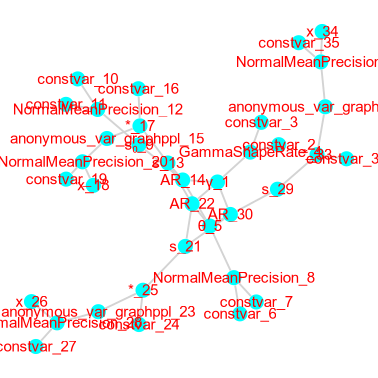

In [123]:
GraphPlot.gplot( ## existing plotting functionality
    lar_meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(lar_meta_graph)),
    nodelabelsize=1.0,
    NODESIZE=0.05, ## diameter of the nodes
    nodelabelc="red", #.
    nodelabeldist=0.0,
    nodefillc="cyan",
)

# GraphViz DOT Code Generation and Visualisation

### General Helper Functions:

In [66]:
"""
Takes in the DOT string used with GraphViz.jl and 
strips it of the leading and trailing non-dot syntax.

returns a string containing 'pure' DOT syntax.
"""
function strip_dot_wrappers(dot_string::String)
    stripped_string = replace(dot_string, r"^dot\"\"\"\n" => "")
    stripped_string = replace(stripped_string, r"\n\"\"\"$" => "")
    
    return stripped_string
end

strip_dot_wrappers

In [67]:
"""
Takes a 'pure' DOT-syntax Julia string and writes this to
a .dot file. Intended to be used in combination with 
strip_dot_wrappers
"""
function write_to_dot_file(dot_string::String, file_path::String)
    open(file_path, "w") do file
        write(file, dot_string)
    end
end

write_to_dot_file

In [68]:
"""
Takes a source (src) .dot file and generates a .pdf
render of the encoded graph. PDF render is saved to 
the destination (dst) .pdf file. 

src_dot_file_path is assumed to be 'some_path/some_name.dot' and
dst_pdf_file_path_name is assumed to be 'some_path/some_name.pdf'. 
That is, both file extensions should be specified. 
"""
function generate_pdf_from_dot(
        src_dot_file_path::String, 
        dst_pdf_file_path_name::String
    )
    run(`dot -Tpdf $src_dot_file_path -o $dst_pdf_file_path`)
end

generate_pdf_from_dot

In [75]:
"""
This function encapsulates the above three functions.
"""
function dot_string_to_pdf(
        dot_string::String, 
        dst_pdf_file::String
    )
    
    pure_dot_string = strip_dot_wrappers(dot_string)
    write_to_dot_file(pure_dot_string, "tmp.dot")
    generate_pdf_from_dot("tmp.dot", dst_pdf_file)
    rm("tmp.dot")
    
end

dot_string_to_pdf

In [87]:
function meta_graph_to_pdf(
        file_name::String,
        meta_graph::MetaGraph
    )

    layout=(args...)->spring_layout(args...; C=2)

    draw(
        PDF(
            "$file_name", 30cm, 30cm
        ), GraphPlot.gplot(
            meta_graph,
            layout=layout,
            nodelabel=collect(labels(meta_graph)),
            nodelabelsize=1.0,
            NODESIZE=0.05, # diameter of the nodes,
            nodelabelc="green",
            nodelabeldist=2.0,
            nodefillc="blue",
            edgestrokec="red",
            EDGELINEWIDTH = 0.8
        )
    )
end

meta_graph_to_pdf (generic function with 1 method)

### LearnableLoop.com Helper Functions:
See this link for more on these functions: https://learnableloop.com/posts/FFGViz1_KE.html

In [9]:
"""
 Retain canonical chars of a label string.
 From learnableloop.com at: https://learnableloop.com/posts/FFGViz1_KE.html
"""
function retain_can(s::String)
    m = match(r"^[a-zA-Zγθs₀\*]*", s)
    return m.match
end

retain_can

In [10]:
"""
Given a user specified canonical factor label string, 
returns all the GraphPPL associated labels from the context's factor_nodes.
From learnableloop.com at: https://learnableloop.com/posts/FFGViz1_KE.html
"""
function str_factors(gppl_model, factor::String)
    context = GraphPPL.getcontext(gppl_model)
    vec = []
    for (factor_ID, factor_label) in pairs(context.factor_nodes)
        ## println("$(factor_ID), $(factor_label)")
        ## println("$(typeof(factor_ID)), $(typeof(factor_label))")
        node_data = gppl_model[factor_label]
        ## println("$(node_data.properties.fform)\n")
        if retain_can(string(node_data.properties.fform)) == factor
            append!(vec, factor_label)
        end
    end
    result = join(string.(vec), "; ")
    return result
end

str_factors

In [11]:
"""
Given a user specified canonical variable label string, 
returns all the GraphPPL associated labels from the context's individual_variables.
From learnableloop.com at: https://learnableloop.com/posts/FFGViz1_KE.html
"""
function str_individual_vars(gppl_model, var::String)
    context = GraphPPL.getcontext(gppl_model)
    vec = []
    for (node_ID, node_label) in pairs(context.individual_variables)
        ## println("$(node_ID), $(node_label)")
        ## println("$(typeof(node_ID)), $(typeof(node_label))")
        if string(node_ID) == var
            append!(vec, node_label)
        end
    end
    result = join(string.(vec), "; ")
    return result
end

str_individual_vars

In [12]:
"""
Given a user specified canonical variable label string, 
returns all the GraphPPL associated labels from the context's vector_variables.
From learnableloop.com at: https://learnableloop.com/posts/FFGViz1_KE.html
"""
function str_vector_vars(gppl_model, var::String)
    context = GraphPPL.getcontext(gppl_model)
    vec = []
    for (node_ID, node_label) in pairs(context.vector_variables)
        ## println("$(node_ID), $(node_label)")
        ## println("$(typeof(node_ID)), $(typeof(node_label))")
        if string(node_ID) == var
            append!(vec, node_label)
        end
    end
    result = join(string.(vec), "; ")
    return result
end

str_vector_vars

The following are specifically for use with the FFG visualization.

In [138]:
"""
Takes the tikz string given by generate_tikz() and 
writes it to a .tex file to produce a TikZ visualisation. 
"""
function show_tikz(tikz_code_graph::String)
    ## eval(Meta.parse(dot_code_graph)) ## for GraphViz

    ## see problem in ^v1 under TikzPictures section 
    ## tikz_picture = TikzPicture(tikz_code_graph)
    ## return tikz_picture
    file_path = "myoutput.tex" ## write to file rather than show in notebook
    open(file_path, "w") do file
        write(file, tikz_code_graph)
    end
end

show_tikz

In [139]:
function retain_can(s::String) ## retain canonical chars of a label string
    m = match(r"^[a-zA-Zγθs₀\*]*", s)
    return m.match
end

retain_can (generic function with 1 method)

In [140]:
function sanitized(vertex::String)
    if haskey(_san_node_ids, vertex)
        return _san_node_ids[vertex]
    else
        return vertex
    end
end

sanitized (generic function with 1 method)

In [141]:
function lup(label::String)
    if _lup_enabled
        lup_label = get(_lup_dict, label, replace(label, "_" => "\\_"))
    else
        return replace(label, "_" => "\\_")
    end
end

lup (generic function with 1 method)

In [142]:
function seqlup(label::String, i::Integer)
    if _seqlup_enabled
        lup_label = get(_lup_dict, label, split(label, '_')[1]*"_"*string(i))
        return lup_label
    else
        return replace(label, "_" => "\\_")
    end
end

seqlup (generic function with 1 method)

In [143]:
function show_meta_graph(meta_graph) ## just for info
    str = ""
    for i in MetaGraphsNext.vertices(meta_graph)
        label = MetaGraphsNext.label_for(meta_graph, i)
        str *= "    $(label);\n"
    end
    for edge in MetaGraphsNext.edges(meta_graph)
        source_vertex = MetaGraphsNext.label_for(meta_graph, edge.src)
        dest_vertex = MetaGraphsNext.label_for(meta_graph, edge.dst)
        str *= "    $(source_vertex) -- $(dest_vertex);\n"
    end
    print(str)
end

show_meta_graph (generic function with 1 method)

In [144]:
"""
Given a user specified canonical factor label string, 
returns all the GraphPPL associated labels from the context's factor_nodes.
"""
function str_facs(gppl_model, factor::String)
    context = GraphPPL.getcontext(gppl_model)
    vec = []
    for (factor_ID, factor_label) in pairs(context.factor_nodes)
        ## println("$(factor_ID), $(factor_label)")
        ## println("$(typeof(factor_ID)), $(typeof(factor_label))")
        node_data = gppl_model[factor_label]
        ## println("$(node_data.properties.fform)\n")
        if retain_can(string(node_data.properties.fform)) == factor
            append!(vec, factor_label)
        end
    end
    result = string.(vec)
    return result
end

str_facs

In [145]:
"""
Given a user specified canonical variable label string, 
returns all the GraphPPL associated labels from the context's individual_variables.
"""
function str_individual_vars(gppl_model, var::String)
    context = GraphPPL.getcontext(gppl_model)
    vec = []
    for (node_ID, node_label) in pairs(context.individual_variables)
        ## println("$(node_ID), $(node_label)")
        ## println("$(typeof(node_ID)), $(typeof(node_label))")
        if occursin(var, string(node_ID))
            append!(vec, node_label)
        end
    end
    result = string.(vec)
    return result
end

str_individual_vars

In [146]:
"""
Given a user specified canonical variable label string, 
returns all the GraphPPL associated labels from the context's vector_variables.
"""
function str_vector_vars(gppl_model, var::String)
    context = GraphPPL.getcontext(gppl_model)
    vec = []
    for (node_ID, node_label) in pairs(context.vector_variables)
        ## println("$(node_ID), $(node_label)")
        ## println("$(typeof(node_ID)), $(typeof(node_label))")
        if string(node_ID) == var
            append!(vec, node_label)
        end
    end
    result = string.(vec)
    return result
end

str_vector_vars

In [147]:
function spaces(n::Int)
    d = 1/(n + 1)
    return [i*d for i in 1:n]
end

spaces (generic function with 1 method)

In [148]:
function setup_divn(n)
    divn = Dict()
    for i in 1:n
        divn[i] = spaces(i)
    end
    return divn
end

setup_divn (generic function with 1 method)

In [149]:
_ytop = 15 ## grid y-value at the top of picture

15

# Automatic TikZ String Generation:

In [150]:
function get_preamble_and_postamble(heading)
    iob = IOBuffer() ## preamble
    write(iob, "\\documentclass{standalone}\n")
    write(iob, "\\usepackage{tikz}\n")
    write(iob, "\\usepackage{amsmath}\n")
    write(iob, "\\newcommand\\ns{10mm} %define node (minimum) size\n")
    write(iob, "\\DeclareUnicodeCharacter{03B8}{\\theta}\n")
    write(iob, "\\DeclareUnicodeCharacter{03B3}{\\gamma}\n")
    ## write(iob, "\\DeclareUnicodeCharacter{2080}{\\0}\n") ## theta_0
    write(iob, "\\begin{document}\n")
    write(iob, "\\begin{tikzpicture}[\n")
    write(iob, "    scale=1, \n")
    write(iob, "    draw=black, \n")
    write(iob, "    fac/.style={rectangle, draw=black!100, fill=black!0, minimum size=\\ns, inner sep=0pt},\n")
    write(iob, "    dlt/.style={rectangle, draw=black!100, fill=black!100, minimum size=.3*\\ns},\n")
    write(iob, "    var/.style={circle, draw=gray!100, fill=gray!100, minimum size=1mm, inner sep=0pt},\n")
    write(iob, "    bus/.style={rectangle, draw=black!100, fill=black!100, minimum width=30mm, minimum height=.5mm, inner sep=0pt},\n")
    write(iob, "    eql/.style={rectangle, draw=black!100, fill=black!0, minimum size=.5*\\ns},\n")
    write(iob, "    text=gray,\n")
    write(iob, "    ]\n") 
    write(iob, "\\node[font=\\Large] at (4,$(_ytop)) { };\n")
    write(iob, "\\node[font=\\Large] at (4,$(_ytop-1)) {\\textbf{$(heading)}};\n")
    ## write(iob, "\\draw[lightgray] (0,0) grid (18,9);\n")
    preamble = String(take!(iob))
    print(preamble)
    println("⋮"); println("⋮"); println("⋮") ## [\]vdots[tab]

    iob = IOBuffer() ## postamble
    write(iob, "\\end{tikzpicture}\n")
    write(iob, "\\end{document}\n")
    postamble = String(take!(iob))
    print(postamble)

    return preamble, postamble
end

get_preamble_and_postamble (generic function with 1 method)

In [151]:
function generate_tikz(;
        heading::String,
        Model::GraphPPL.Model,
        layers::Vector{String}, 

        iniparamB1_vars=nothing,
        paramB1_var_uname=nothing,
        iniparamB1_fac=nothing,

        iniparamB2_vars=nothing,
        paramB2_var_uname=nothing,
        iniparamB2_fac=nothing,

        inistate1_vars=nothing,
        inistate1_fac=nothing,
        state10_var=nothing,
        state1_var_uname=nothing,
        trans1_facs=nothing,

        inistate2_vars=nothing,
        inistate2_fac=nothing,
        state20_var=nothing,
        state2_var_uname=nothing,
        trans2_facs=nothing,
        trans2_pars=nothing,

        inistate3_vars=nothing,
        inistate3_fac=nothing,
        state30_var=nothing,
        state3_var_uname=nothing,
        trans3_facs=nothing,
        trans3_pars=nothing,

        obser_var_uname=nothing,
        obser_facs=nothing,
        obser_pars=nothing,

        iniparamA_vars=nothing,
        iniparamA_fac=nothing,
        paramA_var_uname=nothing
    )    
    preamble, postamble = get_preamble_and_postamble(heading)
    tikz = preamble
    divn = setup_divn(15)
    iob = IOBuffer() ## graph
    if "paramB1" in layers
        paramB1_vars = str_individual_vars(Model, paramB1_var_uname)
    end
    if "paramB2" in layers
        paramB2_vars = str_individual_vars(Model, paramB2_var_uname)
    end
    if "state1" in layers
        state1_vars = str_vector_vars(Model, state1_var_uname)
    end
    if "state2" in layers
        if state2_var_uname != "" 
            state2_vars = str_vector_vars(Model, state2_var_uname) 
        else 
            state2_vars = Vector{String}() 
        end
    end
    if "state3" in layers
        if state3_var_uname != "" 
            state3_vars = str_vector_vars(Model, state3_var_uname) 
        else 
            state3_vars = Vector{String}() 
        end
    end
    if "obser" in layers
        obser_vars = str_vector_vars(Model, obser_var_uname)
    end
    if "paramA" in layers
        paramA_vars = str_individual_vars(Model, paramA_var_uname)
    end
    ytop = _ytop; xleft = 0; ysep = 3; xsep = 2; y = ytop; x = xleft
    write(iob, "%% --------------------------- NODES ---------------------------\n")
    if "paramB1" in layers
        y -= ysep; x = xleft
        for (i,v) in enumerate(iniparamB1_vars)
            write(iob, "\\node($(v))[var] at ($(x), $(y) - 0.5+$(divn[length(iniparamB1_vars)][i])) {};\n")
            write(iob, "\\node[left] at ($(v)) {\$$(lup(v))\$};\n") ## label
        end; x += xsep
        write(iob, "\\node($(iniparamB1_fac))[fac] at ($(x), $(y)) {\$$(lup(iniparamB1_fac))\$};\n")
        x += xsep
        for (i,v) in enumerate(paramB1_vars)
            write(iob, "\\node($(v))[eql] at ($(x), $(y)) {\$=\$};\n")
            write(iob, "\\node[xshift=.4*\\ns, yshift=.4*\\ns] at ($(v)) {\$$(lup(v))\$};\n") ## label
        end
    end
    if "paramB2" in layers
        y -= ysep; x = xleft
        for (i,v) in enumerate(iniparamB2_vars)
            write(iob, "\\node($(v))[var] at ($(x), $(y) - 0.5+$(divn[length(iniparamB2_vars)][i])) {};\n")
            write(iob, "\\node[left] at ($(v)) {\$$(lup(v))\$};\n") ## label
        end; x += xsep
        write(iob, "\\node($(iniparamB2_fac))[fac] at ($(x), $(y)) {\$$(lup(iniparamB2_fac))\$};\n")
        x += xsep
        for (i,v) in enumerate(paramB2_vars)
            write(iob, "\\node($(v))[eql] at ($(x), $(y)) {\$=\$};\n")
            write(iob, "\\node[xshift=.4*\\ns, yshift=.4*\\ns] at ($(v)) {\$$(lup(v))\$};\n") ## label
        end
    end
    if "state1" in layers
        y -= ysep; x = xleft
        for (i,v) in enumerate(inistate1_vars)
            write(iob, "\\node($(v))[var] at ($(x), $(y) - 0.5+$(divn[length(inistate1_vars)][i])) {};\n")
            write(iob, "\\node[left] at ($(v)) {\$$(lup(v))\$};\n") ## label
        end
        x += xsep
        write(iob, "\\node($(inistate1_fac))[fac] at ($(x), $(y)) {\$$(lup(inistate1_fac))\$};\n")
        x += xsep
        write(iob, "\\node($(state10_var))[var] at ($(x), $(y)) {};\n")
        ## write(iob, "\\node[above] at ($(state10_var)) {\$s_0\$};\n") ## label
        write(iob, "\\node[above] at ($(state10_var)) {\$$(lup(state10_var))\$};\n") ## label        
        x += xsep
        for (i,v) in enumerate(trans1_facs)
            write(iob, "\\node($(v))[fac] at ($(x), $(y)) {\$$(lup(v))\$};\n")
            x += 2*xsep
        end
        x = 4*xsep     
        for (i,v) in enumerate(state1_vars)
            if i < length(state1_vars)
                write(iob, "\\node($(v))[eql] at ($(x), $(y)) {\$=\$};\n")            
                write(iob, "\\node[xshift=.4*\\ns, yshift=.4*\\ns] at ($(v)) {\$$(seqlup(v, i))\$};\n") ## label
            else
                write(iob, "\\node($(v))[var] at ($(x), $(y)) {};\n")
                write(iob, "\\node[above] at ($(v)) {\$$(seqlup(v, i))\$};\n") ## label
            end
            x += 2*xsep
        end
    end
    if "state2" in layers
        y -= ysep; x = xleft
        x = 4*xsep
        for (i,v) in enumerate(trans2_facs)
            write(iob, "\\node($(v))[fac] at ($(x), $(y)) {\$$(lup(v))\$};\n")
            x += 2*xsep
        end
        x = 4*xsep             
        for (i,v) in enumerate(trans2_pars)
            write(iob, "\\node($(v))[var] at ($(x)-1, $(y)) {};\n")
            write(iob, "\\node[left] at ($(v)) {\$$(lup(v))\$};\n") ## label
            x += 2*xsep
        end
        x = 4*xsep     
        for (i,v) in enumerate(state2_vars)
            if i < length(state2_vars)
                write(iob, "\\node($(v))[eql] at ($(x), $(y)) {\$=\$};\n")            
                write(iob, "\\node[xshift=.4*\\ns, yshift=.4*\\ns] at ($(v)) {\$$(seqlup(v, i))\$};\n") ## label
            else
                write(iob, "\\node($(v))[var] at ($(x), $(y)) {};\n")
                write(iob, "\\node[above] at ($(v)) {\$$(seqlup(v, i))\$};\n") ## label
            end
            x += 2*xsep
        end
    end
    if "state3" in layers
        y -= ysep; x = xleft
        x = 4*xsep
        for (i,v) in enumerate(trans3_facs)
            write(iob, "\\node($(v))[fac] at ($(x), $(y)) {\$$(lup(v))\$};\n")
            x += 2*xsep
        end
        x = 4*xsep             
        for (i,v) in enumerate(trans3_pars)
            write(iob, "\\node($(v))[var] at ($(x)-1, $(y)) {};\n")
            write(iob, "\\node[left] at ($(v)) {\$$(lup(v))\$};\n") ## label
            x += 2*xsep
        end
        x = 4*xsep     
        for (i,v) in enumerate(state3_vars)
            if i < length(state3_vars)
                write(iob, "\\node($(v))[eql] at ($(x), $(y)) {\$=\$};\n")            
                write(iob, "\\node[xshift=.4*\\ns, yshift=.4*\\ns] at ($(v)) {\$$(seqlup(v, i))\$};\n") ## label
            else
                write(iob, "\\node($(v))[var] at ($(x), $(y)) {};\n")
                write(iob, "\\node[above] at ($(v)) {\$$(seqlup(v, i))\$};\n") ## label
            end
            x += 2*xsep
        end
    end
    if "obser" in layers 
        y -= ysep; x = 4*xsep
        for (i,v) in enumerate(obser_facs)
            write(iob, "\\node($(v))[fac] at ($(x), $(y)) {\$$(lup(v))\$};\n")
            x += 2*xsep
        end
        x = 4*xsep             
        for (i,v) in enumerate(obser_pars)
            write(iob, "\\node($(v))[var] at ($(x)-1, $(y)) {};\n")
            write(iob, "\\node[left] at ($(v)) {\$$(lup(v))\$};\n") ## label
            x += 2*xsep
        end
        y -= 2; x = 4*xsep             
        for (i,v) in enumerate(obser_vars)
            write(iob, "\\node($(v))[var] at ($(x), $(y)) {};\n")
            write(iob, "\\node[above right] at ($(v)) {\$$(seqlup(v, i))\$};\n") ## label
            x += 2*xsep
        end
    end
    if "paramA" in layers
        y -= ysep; x = xleft
        for (i,v) in enumerate(iniparamA_vars)
            write(iob, "\\node($(v))[var] at (1, $(y) - 0.5+$(divn[length(iniparamA_vars)][i])) {};\n")
            write(iob, "\\node[left] at ($(v)) {\$$(lup(v))\$};\n") ## label
        end
        x += xsep
        write(iob, "\\node($(iniparamA_fac))[fac] at ($(x), $(y)) {\$$(lup(iniparamA_fac))\$};\n")
        x = 4*xsep - .5*xsep ## last term is west-entry offset
        ## x += xsep
        for (i,v) in enumerate(paramA_vars)
            ## write(iob, "\\node($(v))[bus, minimum width=30mm, minimum height=.5mm, inner sep=0pt] at (8, $(y)) {};\n")
            write(iob, "\\node($(v))[eql] at ($(x), $(y)) {\$=\$};\n")
            write(iob, "\\node[xshift=.4*\\ns, yshift=.4*\\ns] at ($(v)) {\$$(lup(v))\$};\n") ## label
        end
    end
    
    write(iob, "%% --------------------------- LINKS ---------------------------\n")
    y = ytop; x = xleft
    if "paramB1" in layers
        for (i,v) in enumerate(iniparamB1_vars)
            write(iob, "\\draw ($(v)) -- ([shift={(0, $(divn[length(iniparamB1_vars)][i]))}]$(iniparamB1_fac).south west);\n")
        end; x += xsep
        write(iob, "\\draw ($(iniparamB1_fac)) -| ($(paramB1_vars[1]));\n"); x += 2*xsep
        if "state1" in layers ## connect paramB1 layer to state1 layer
            for (i,v) in enumerate(trans1_facs)
                write(iob, "\\draw ($(paramB1_vars[1])) -| ([shift={(-.2*\\ns, 0)}]$(trans1_facs[i]).north east);\n")
            end
        end
    end
    if "paramB2" in layers
        y -= ysep; x = xleft
        for (i,v) in enumerate(iniparamB2_vars)
            write(iob, "\\draw ($(v)) -- ([shift={(0, $(divn[length(iniparamB2_vars)][i]))}]$(iniparamB2_fac).south west);\n")
        end; x += xsep
        write(iob, "\\draw ($(iniparamB2_fac)) -| ($(paramB2_vars[1]));\n"); x += 2*xsep
        if "state1" in layers ## connect paramB2 layer to state1 layer
            for (i,v) in enumerate(trans1_facs)    
                write(iob, "\\draw ($(paramB2_vars[1])) -| ([shift={(.2*\\ns, 0)}]$(trans1_facs[i]).north west);\n")
            end
        end            
    end
    if "state1" in layers ## state vars in this layer
        for (i,v) in enumerate(inistate1_vars)
            write(iob, "\\draw ($(v)) -- ([shift={(0, $(divn[length(inistate1_vars)][i]))}]$(inistate1_fac).south west);\n")
        end
        write(iob, "\\draw ($(inistate1_fac)) -| ($(state10_var));\n")
        for (i,v) in enumerate(trans1_facs)
            write(iob, "\\draw ($(v)) -- ($(state1_vars[i]).west);\n")
        end
        tmp = [state10_var; state1_vars]
        for (i,v) in enumerate(trans1_facs)
            write(iob, "\\draw ($(v).west) -- ($(tmp[i]).east);\n")
        end
        if "state2" in layers ## connect state1 layer to state2 layer
            for (i,v) in enumerate(state1_vars)    
                write(iob, "\\draw ($(state1_vars[i])) -- ($(trans2_facs[i]));\n")
            end
        elseif "state3" in layers ## connect state1 layer to state2 layer
            for (i,v) in enumerate(state1_vars)    
                write(iob, "\\draw ($(state1_vars[i])) -- ($(trans3_facs[i]));\n")
            end
        else
            for (i,v) in enumerate(state1_vars)
                write(iob, "\\draw ($(v)) -- ($(obser_facs[i]).north);\n")
            end
        end
    end
    if "state2" in layers
        for (i,v) in enumerate(inistate2_vars)
            write(iob, "\\draw ($(v)) -- ([shift={(0, $(divn[length(inistate2_vars)][i]))}]$(inistate2_fac).south west);\n")
        end
        if "state3" in layers ## connect state1 layer to state2 layer
            for (i,v) in enumerate(trans2_facs) 
                write(iob, "\\draw ($(trans2_facs[i])) -- ($(trans3_facs[i]));\n")
            end
        end
    end
    if "state3" in layers
        if "obser" in layers ## connect state1 layer to state2 layer
            for (i,v) in enumerate(trans3_facs) 
                write(iob, "\\draw ($(trans3_facs[i])) -- ($(obser_facs[i]));\n")
            end
        end
    end
    if "obser" in layers
        for (i,v) in enumerate(obser_vars)
            write(iob, "\\draw ($(obser_facs[i])) -- ($(obser_vars[i]));\n")
        end
    end
    if "paramA" in layers
        for (i,v) in enumerate(iniparamA_vars)
            ## write(iob, "\\draw[blue, line width=3pt] ($(v)) -- ([shift={(0, $(divn[length(iniparamA_vars)][i]))}]$(iniparamA_fac).south west);\n")
            write(iob, "\\draw ($(v)) -- ([shift={(0, $(divn[length(iniparamA_vars)][i]))}]$(iniparamA_fac).south west);\n")
        end
        write(iob, "\\draw ($(iniparamA_fac)) -| ($(paramA_vars[1]));\n")
        for i in obser_facs
            write(iob, "\\draw ($(paramA_vars[1])) -| ([shift={(-.5*\\ns,0)}]$(i).west) -- ($(i));\n")
        end
    end

    ## DRAW ALL RAW LINKS FOR REFERENCE
    if _raw_links_enabled
        G = Model.graph
        for edge in MetaGraphsNext.edges(G)
            source_vertex = MetaGraphsNext.label_for(G, edge.src)
            dest_vertex = MetaGraphsNext.label_for(G, edge.dst)
            write(iob, "\\draw[dotted, red, line width=1pt] ($(source_vertex)) -- ($(sanitized(string(dest_vertex))));\n")
        end
    end
    ## WRITE EQUAL NODES AGAIN
    if "paramB1" in layers
        for (i,v) in enumerate(paramB1_vars)
            write(iob, "\\node($(v))[eql] at ($(v)) {\$=\$};\n")
        end
    end
    if "paramB2" in layers
        for (i,v) in enumerate(paramB2_vars)
            write(iob, "\\node($(v))[eql] at ($(v)) {\$=\$};\n")
        end
    end
    if "paramA" in layers
        for (i,v) in enumerate(paramA_vars)
            write(iob, "\\node($(v))[eql] at ($(v)) {\$=\$};\n")
        end        
    end
    graph = String(take!(iob))
    tikz *= graph
    tikz *= postamble
    return tikz
end

generate_tikz (generic function with 1 method)

### Automatic DOT String Generation:

In [13]:
"""
Parses the input GraphPPL.Model and uses Base.IOBuffer to 
iteratively construct a Julia string, containing the DOT 
code for the GraphViz visualisation of the graph. This 
string is then returned. 

Currently isomorphic to the display given by GraphPlot.gplot.
"""
function generate_dot(; 
        Model::GraphPPL.Model, font_size::Int, 
        edge_length::Float64 = 1.0, layout::String="neato", 
        width::Float64=10.0, height::Float64=10.0,
    )
    
    meta_graph = Model.graph # underlying MetaGraphsNext graph
    
    io_buffer = IOBuffer() # use Base.IOBuffer rather than sucessive string concatenation
    
    write(io_buffer, "dot\"\"\"\ngraph G {\n")
    write(io_buffer, "    layout=$(layout);\n")
    write(io_buffer, "    size=\"$(width),$(height)!\";\n")
    write(io_buffer, "    node [shape=circle, fontsize=$(font_size)];\n") # write initial graph DOT code to the Base.IOBuffer
    
    # Vertices/Nodes
    for vertex in MetaGraphsNext.vertices(meta_graph)
        label = MetaGraphsNext.label_for(meta_graph, vertex)
        
        properties = Model[label].properties # for dsistnguishing factor/variable nodes
        
        if isa(properties, GraphPPL.FactorNodeProperties) # Factor node
            write(io_buffer, "    \"$(label)\" [shape=square, style=filled, fillcolor=lightgray];\n")
        elseif isa(properties, GraphPPL.VariableNodeProperties) # Variable Node
            write(io_buffer, "    \"$(label)\" [shape=circle];\n")
        else
            println("ERROR: Unknown node type for label $(label)")
        end
    end
    
    # Edges
    for edge in MetaGraphsNext.edges(meta_graph)
        source_vertex = MetaGraphsNext.label_for(meta_graph, edge.src)
        dest_vertex = MetaGraphsNext.label_for(meta_graph, edge.dst)
        write(io_buffer, "    \"$(source_vertex)\" -- \"$(dest_vertex)\" [len=$(edge_length)];\n")
    end
    
    write(io_buffer, "}\n\"\"\"")
    
    final_dot_code = String(take!(io_buffer))
    
    return final_dot_code
    
end

generate_dot

In [14]:
"""
Parses the input GraphPPL.Model and uses Base.IOBuffer to 
iteratively construct a Julia string, containing the DOT 
code for the GraphViz visualisation of the graph. This 
string is then returned. 

Iteration is performed by means of
a BFS traversal from the initially created node. Particuar
BFS traversal technique based on that found in the implementation
of _bfs_parents at: 

https://github.com/JuliaGraphs/Graphs.jl/blob/f97b4afd17e1cd938e53282bcb76c1b8e2ea127c/src/traversals/bfs.jl#L21-L34

Currently isomorphic to the display given by GraphPlot.gplot.
"""

function generate_dot_BFS(;
        Model::GraphPPL.Model, font_size::Int, 
        edge_length::Float64 = 1.0, layout::String="neato", 
        width::Float64=10.0, height::Float64=10.0
    )
        
    n = nv(Model) # number of vertices
    visited = falses(n) # array of visited nodes
    parents = zeros(Int, n) # array to store parent of each vertex in BFS traversal.
    cur_level = Vector{Int}() # empty vector to keep track of current level of nodes processed in BFS.
    sizehint!(cur_level, n)
    next_level = Vector{Int}()
    sizehint!(next_level, n)
    k = 0
    
    s = 1 # source node
    io_buffer = IOBuffer()
    
    write(io_buffer, "dot\"\"\"\ngraph G {\n")
    write(io_buffer, "    layout=$(layout);\n")
    write(io_buffer, "    size=\"$(width),$(height)!\";\n")
    write(io_buffer, "    node [shape=circle, fontsize=$(font_size)];\n")
    
    if !visited[s]
        visited[s] = true
        push!(cur_level, s)
        parents[s] = s
        k += 1
    end
    while !isempty(cur_level)
        for v in cur_level
            for v_neighb in MetaGraphsNext.neighbors(Model.graph, v) # v_neighb should be element in MetaGraphsNext.vertices(meta_graph)
                if !visited[v_neighb]

                    # node/vertex data:
                    label = MetaGraphsNext.label_for(Model.graph, v_neighb)
        
                    properties = Model[label].properties # for dsistnguishing factor/variable nodes

                    if isa(properties, GraphPPL.FactorNodeProperties) # Factor node
                        write(io_buffer, "    \"$(label)\" [shape=square, style=filled, fillcolor=lightgray];\n")
                    elseif isa(properties, GraphPPL.VariableNodeProperties) # Variable Node
                        write(io_buffer, "    \"$(label)\" [shape=circle];\n")
                    else
                        println("ERROR: Unknown node type for label $(label)")
                    end
                    
                    # edge data:                    
                    v_label = MetaGraphsNext.label_for(Model.graph, v)
                    v_neighb_label = MetaGraphsNext.label_for(Model.graph, v_neighb)
                    
                    write(io_buffer, "    \"$(v_label)\" -- \"$(v_neighb_label)\" [len=$(edge_length)];\n")
                    
                    push!(next_level, v_neighb)
                    parents[v_neighb] = v
                    visited[v_neighb] = true
                    k += 1
                        
                end
            end

            if k == n
                write(io_buffer, "}\n\"\"\"")
    
                final_dot_code = String(take!(io_buffer))
                    
                return final_dot_code, parents
            end
        end
        empty!(cur_level)
        cur_level, next_level = next_level, cur_level
        sort!(cur_level)
    end
    
    write(io_buffer, "}\n\"\"\"")
    
    final_dot_code = String(take!(io_buffer))

    return final_dot_code, parents
end

generate_dot_BFS (generic function with 1 method)

In [15]:
"""
Parses the input GraphPPL.Model and uses Base.IOBuffer to 
iteratively construct a Julia string, containing the DOT 
code for the GraphViz visualisation of the graph. This 
string is then returned. 
Currently isomorphic to the display given by GraphPlot.gplot.

From learnableloop.com at: https://learnableloop.com/posts/FFGViz1_KE.html
"""
function generate_dot_ll(; 
        Model::GraphPPL.Model, 
        digraph::Bool=false,
        font_size::Int, 
        edge_length::Float64 = 1.0, 
        layout::String="neato", 
        ranksep=1.0, 
        rank::Bool=false,
        splines="line",
     
        paramvar="θ", ## inferred param
        param_prior_factor="",

        statevar="s", ## inferred state
        state_prior_factor="",

        datafactor="", ## factors connecting to datavar
        datavar="x", 
     
        busvars=[], ## variables on a 'bus', usually connecting to more than 2 factors
        deltas::Bool=false, ## to add delta clamps as black squares
        width::Float64=10.0, height::Float64=10.0,
    )
    if digraph==true 
        edge_symbol = "->" 
        graph = "digraph"
    else 
        edge_symbol = "--" 
        graph = "graph"
    end
    meta_graph = Model.graph ## underlying MetaGraphsNext graph
    io_buffer = IOBuffer() ## Base.IOBuffer rather than successive string concatenation
    write(io_buffer, "dot\"\"\"\n$(graph) G {\n")
    write(io_buffer, "    layout=$(layout);\n")
    write(io_buffer, "    rankdir=TB;\n")
    # write(io_buffer, "    ranksep=.1;\n")
    write(io_buffer, "    ranksep=$(ranksep);\n")
    write(io_buffer, "    splines=$(splines);\n")
    write(io_buffer, "    size=\"$(width),$(height)!\";\n")
    write(io_buffer, ## write initial graph DOT code to the Base.IOBuffer
    """
        node [
            shape=circle, 
            fontsize=$(font_size), 
            ## style=filled, 
            ## fillcolor=lightgray, 
            ## margin=.02, 
            margin=.01, 
            ## width=.10, height=.10, //minimum size (inches), grows to contain label
            ## width=.10, height=.10, fixedsize=true, //fixed size (inches), does not grow to contain label
            width=.30, height=.30, fixedsize=true, //fixed size (inches), does not grow to contain label
            color=black,
            penwidth=0.2, 
        ]
        edge[
            color=black, 
            penwidth=0.2, 
            len=$(edge_length), 
        ];\n
    """)
    ## Vertices/Nodes
    for vertex in MetaGraphsNext.vertices(meta_graph)
        label = MetaGraphsNext.label_for(meta_graph, vertex)
        properties = Model[label].properties ## for distinguishing factor/variable nodes
        if isa(properties, GraphPPL.FactorNodeProperties) ## Factor node
            can_label = retain_can(string(properties.fform))
            ## if can_label == "*" can_label = "STAR" end
            if can_label == "*" 
                write(io_buffer, 
                """
                    \"$(label)\" [
                        label="*",
                        shape=box, 
                        style=filled, 
                        fillcolor=lightgray, 
                    ];\n
                """) 
            else
                write(io_buffer, 
                """
                    \"$(label)\" [
                        label=$(can_label),
                        shape=box, 
                        style=filled, 
                        fillcolor=lightgray, 
                    ];\n
                """) #.
            end
        elseif isa(properties, GraphPPL.VariableNodeProperties) ## Variable Node
            if string(properties.name) == paramvar #.
                can_label = string(Model[label].properties.name) #.
                write(io_buffer, "    \"$(label)\" [label=\"\", xlabel=$(can_label), shape=box, width=1.5, height=.01, fixedsize=true,];\n")
            elseif string(properties.name) == statevar #.
                can_label = string(properties.name)*"_"*string(properties.index) #.
                write(io_buffer, "    \"$(label)\" [label=\"\", xlabel=$(can_label), shape=box, width=1.5, height=.01, fixedsize=true,];\n")
            elseif string(Model[label].properties.name) in busvars #.
                can_label = string(properties.name) #.
                write(io_buffer, "    \"$(label)\" [label=\"\", xlabel=$(can_label), shape=box, width=1.5, height=.01, fixedsize=true,];\n")
            else
                if string(properties.name) == datavar #.
                    can_label = string(properties.name)*"_"*string(properties.index) #.
                    ## write(io_buffer, "    \"$(label)\" [label=\"\", xlabel=$(can_label), shape=circle, width=.01, height=.01, fixedsize=true];\n")
                    write(io_buffer, "    \"$(label)\" [label=$(can_label), shape=circle, width=.01, height=.01, fixedsize=true, color=none];\n")
                    if deltas==true
                        clamp_label = "clamp_"*can_label #.
                        write(io_buffer, "    \"$(clamp_label)\" [label=\"\", shape=box, style=filled, fillcolor=black, width=.05, height=.05, fixedsize=true,];\n") #.
                        write(io_buffer, "    \"$(label)\" $(edge_symbol) \"$(clamp_label)\";\n") #.CURRENT
                    end
                else
                    can_label = string(properties.name) #.
                    write(io_buffer, "    \"$(label)\" [label=$(can_label), shape=circle, width=.01, height=.01, fixedsize=true, color=none];\n") #.
                    if deltas==true
                        clamp_label = "clamp_"*can_label #.
                        write(io_buffer, "    \"$(clamp_label)\" [label=\"\", shape=box, style=filled, fillcolor=black, width=.05, height=.05, fixedsize=true,];\n") #.
                        write(io_buffer, "    \"$(label)\" $(edge_symbol) \"$(clamp_label)\";\n") #.CURRENT
                    end
                end
                ## connect each non-state variable node to a clamp
            end
        else
            println("ERROR: Unknown node type for label $(label)")
        end
    end
    ## Edges
    for edge in MetaGraphsNext.edges(meta_graph)
        source_vertex = MetaGraphsNext.label_for(meta_graph, edge.src)
        dest_vertex = MetaGraphsNext.label_for(meta_graph, edge.dst)
        ## write(io_buffer, "    \"$(source_vertex)\" -- \"$(dest_vertex)\" [len=$(edge_length)];\n")
        write(io_buffer, "    \"$(source_vertex)\" $(edge_symbol) \"$(dest_vertex)\";\n") #.CURRENT
    end
    if rank==true ## ranking with dot layout
        ## No layer for constvars, they will appear close to their connections

        ## Param layer 
        ## write(io_buffer, "subraph cluster_0 {rankdir=LR; rank=same; Beta_6; θ_1;};\n")
        ## write(io_buffer, "{ rank=same; $(get_factors(Model, infer_prior_factor)); $(get_individual_vars(Model, infervar)) };\n")
        if isempty(str_individual_vars(Model, paramvar))
            write(io_buffer, "{ rank=same; $(str_vector_vars(Model, paramvar)) };\n")
        else
            write(io_buffer, "{ rank=same; $(str_individual_vars(Model, paramvar)) };\n")
        end

        ## State layer 
        ## write(io_buffer, "subraph cluster_0 {rankdir=LR; rank=same; Beta_6; θ_1;};\n")
        ## write(io_buffer, "{ rank=same; $(get_factors(Model, infer_prior_factor)); $(get_individual_vars(Model, infervar)) };\n")
        write(io_buffer, "{ rank=same; $(str_vector_vars(Model, statevar)) };\n") #.CURRENT

        ## Data factor layer 
        write(io_buffer, "{ rank=same; $(str_factors(Model, datafactor)) };\n")
        
        ## Data layer
        write(io_buffer, "{ rank=max; $(str_vector_vars(Model, datavar)) };\n") #.CURRENT
        if deltas==true
            write(io_buffer, "{rank=max; clamp_y_1; clamp_y_2; clamp_y_3};\n")
        end

        ## Bus layer
        for i in busvars
            write(io_buffer, "{ rank=max; $(str_individual_vars(Model, i)) };\n")
        end
    end
    write(io_buffer, "}\n\"\"\"")
    final_dot_code = String(take!(io_buffer))
    return final_dot_code
end

generate_dot_ll

### DOT String Execution:

In [16]:
"""
Takes the DOT string given by generate_dot and 
executes it to produce a GraphViz visualisation. 
"""
function show_gv(dot_code_graph::String)
    eval(Meta.parse(dot_code_graph))
end

show_gv

# Example1 - Coin Toss Model:

In [159]:
for i in MetaGraphsNext.vertices(meta_graph)
    label = MetaGraphsNext.label_for(meta_graph, i)
    println("$i: $label")
end

1: θ_1
2: constvar_2
3: constvar_3
4: Beta_4
5: y_5
6: Bernoulli_6
7: y_7
8: Bernoulli_8
9: y_9
10: Bernoulli_10


In [161]:
coin_gppl_model_context = GraphPPL.getcontext(gppl_model)

Context()
 Individual variables: {:constvar_2, :θ, :constvar_3}
 Vector variables: {:y}
 Tensor variables: {}
 Proxies: {}
 Factor nodes: GraphPPL.FactorID[(Beta, 1), (Bernoulli, 2), (Bernoulli, 1), (Bernoulli, 3)]


In [162]:
coin_gppl_model_context.individual_variables

3-element UnorderedDictionary{Symbol, GraphPPL.NodeLabel}
 :constvar_2 │ constvar_2
          :θ │ θ_1
 :constvar_3 │ constvar_3

In [163]:
coin_gppl_model_context.vector_variables

1-element UnorderedDictionary{Symbol, GraphPPL.ResizableArray{GraphPPL.NodeLabel, Vector{GraphPPL.NodeLabel}, 1}}
 :y │ ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_5, y_7, y_9])

In [164]:
coin_gppl_model_context.factor_nodes

4-element UnorderedDictionary{GraphPPL.FactorID, GraphPPL.NodeLabel}
      (Beta, 1) │ Beta_4
 (Bernoulli, 2) │ Bernoulli_8
 (Bernoulli, 1) │ Bernoulli_6
 (Bernoulli, 3) │ Bernoulli_10

In [166]:
str_facs(gppl_model, "Bernoulli")
# str_individual_vars(gppl_model, "θ")
# str_individual_vars(gppl_model, "constvar_2")
# str_vector_vars(gppl_model, "y")

3-element Vector{String}:
 "Bernoulli_8"
 "Bernoulli_6"
 "Bernoulli_10"

In [167]:
show_meta_graph(meta_graph)

    θ_1;
    constvar_2;
    constvar_3;
    Beta_4;
    y_5;
    Bernoulli_6;
    y_7;
    Bernoulli_8;
    y_9;
    Bernoulli_10;
    θ_1 -- Beta_4;
    θ_1 -- Bernoulli_6;
    θ_1 -- Bernoulli_8;
    θ_1 -- Bernoulli_10;
    constvar_2 -- Beta_4;
    constvar_3 -- Beta_4;
    y_5 -- Bernoulli_6;
    y_7 -- Bernoulli_8;
    y_9 -- Bernoulli_10;


In [169]:
_san_node_ids = Dict("dummy" => "dummy")
_lup_enabled = true
_seqlup_enabled = true
_raw_links_enabled = false
_lup_dict = Dict{String, String}(
    "constvar_2_3" => "a",
    "constvar_4_5" => "b",
    "Beta_6" => "\\mathcal{B}eta",
    "Bernoulli_8" => "\\mathcal{B}er",
    "Bernoulli_10" => "\\mathcal{B}er",
    "Bernoulli_12" => "\\mathcal{B}er",
    "θ_1" => "\\theta",
)
coin_tikz = generate_tikz(
    heading = "Coin Toss",
    Model = gppl_model,
    layers = [ ## fac layers, i.e. not var (vars are handled with assoced layer)
        ## "cntrl", 
        ## "paramB1",
        ## "paramB2",
        ## "state1",
        ## "state2",
        ## "state3", 
        "obser", 
        ## "prefr", 
        "paramA"
    ],

    obser_var_uname = "y",
    obser_facs = ["Bernoulli_8", "Bernoulli_10", "Bernoulli_12"],
    obser_pars = [],
    
    iniparamA_vars = ["constvar_2_3", "constvar_4_5"],
    iniparamA_fac = "Beta_6",
    paramA_var_uname="θ"
)
print(coin_tikz)
show_tikz(coin_tikz) ## write to file rather than show in notebook

\documentclass{standalone}
\usepackage{tikz}
\usepackage{amsmath}
\newcommand\ns{10mm} %define node (minimum) size
\DeclareUnicodeCharacter{03B8}{\theta}
\DeclareUnicodeCharacter{03B3}{\gamma}
\begin{document}
\begin{tikzpicture}[
    scale=1, 
    draw=black, 
    fac/.style={rectangle, draw=black!100, fill=black!0, minimum size=\ns, inner sep=0pt},
    dlt/.style={rectangle, draw=black!100, fill=black!100, minimum size=.3*\ns},
    var/.style={circle, draw=gray!100, fill=gray!100, minimum size=1mm, inner sep=0pt},
    bus/.style={rectangle, draw=black!100, fill=black!100, minimum width=30mm, minimum height=.5mm, inner sep=0pt},
    eql/.style={rectangle, draw=black!100, fill=black!0, minimum size=.5*\ns},
    text=gray,
    ]
\node[font=\Large] at (4,15) { };
\node[font=\Large] at (4,14) {\textbf{Coin Toss}};
⋮
⋮
⋮
\end{tikzpicture}
\end{document}
\documentclass{standalone}
\usepackage{tikz}
\usepackage{amsmath}
\newcommand\ns{10mm} %define node (minimum) size
\DeclareUnicodeCharacte

2237

### Coin Toss Model - Existing Functionality:

In [58]:
Graphs.is_cyclic(meta_graph)

false

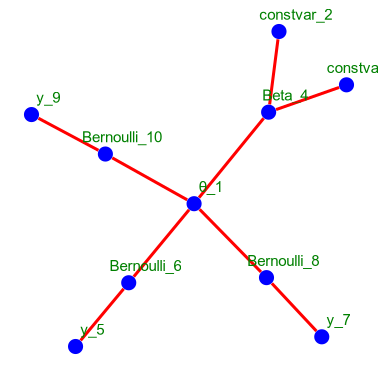

In [17]:
# The existing plotting functionality:
GraphPlot.gplot(
    meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(meta_graph)),
    nodelabelsize=1.0,
    NODESIZE=0.05, # diameter of the nodes,
    nodelabelc="green",
    nodelabeldist=3.0,
    nodefillc="blue",
    edgestrokec="red",
    EDGELINEWIDTH = 0.8
)

In [89]:
# render the meta_graph and save render to a pdf:
meta_graph_to_pdf("coin_toss_viz/coin_toss_GraphPlot.pdf", meta_graph)

### Coin Toss Model - Vanilla generate_dot:

In [18]:
# create the DOT code string
coin_toss_dot = generate_dot(
    Model = gppl_model, 
    font_size = 7,
    edge_length = 1.0,
    layout = "neato",
    width = 6.0,
    height = 6.0
);

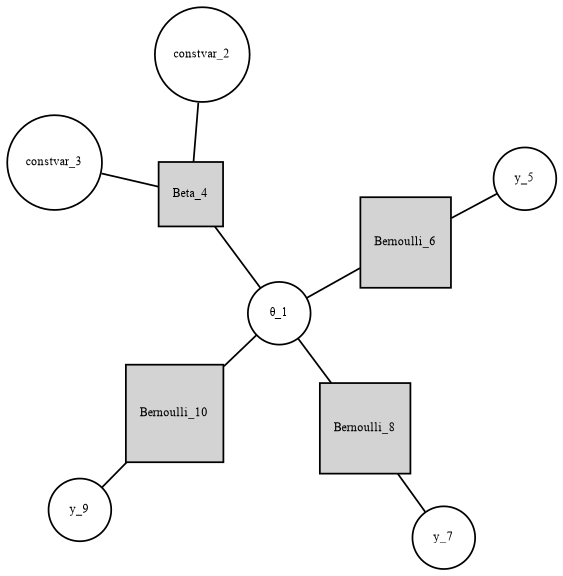

In [19]:
# execute the DOT code string
show_gv(coin_toss_dot)

In [91]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(coin_toss_dot, "coin_toss_viz/coin_toss_pdf_render.pdf")

### Coin Toss Model - BFS generate_dot:

In [28]:
# create the DOT code string
coin_toss_dot_BFS, parents = generate_dot_BFS(
    Model = gppl_model, 
    font_size = 7,
    edge_length = 1.0,
    layout = "neato",
    width = 6.0,
    height = 6.0
);

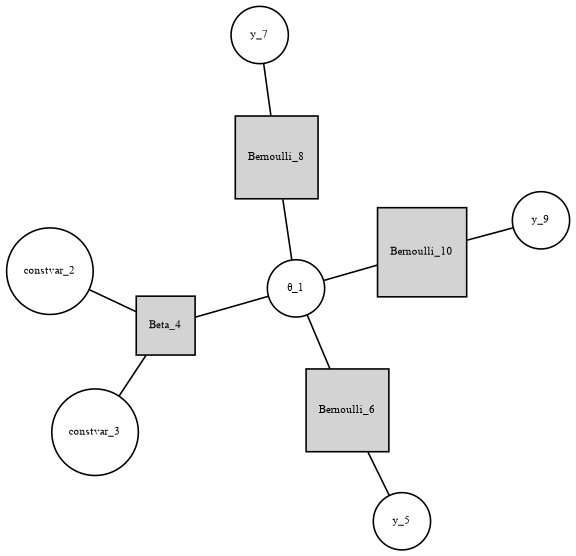

In [29]:
# execute the DOT code string
show_gv(coin_toss_dot_BFS)

### Coin Toss Model - generate_dot learnableloop.com:

In [30]:
# create the DOT code string
coin_toss_dot_ll = generate_dot_ll(
    Model = gppl_model, 
    font_size = 7,
    edge_length = 1.0,
    layout = "neato",
    width = 6.0,
    height = 6.0
);

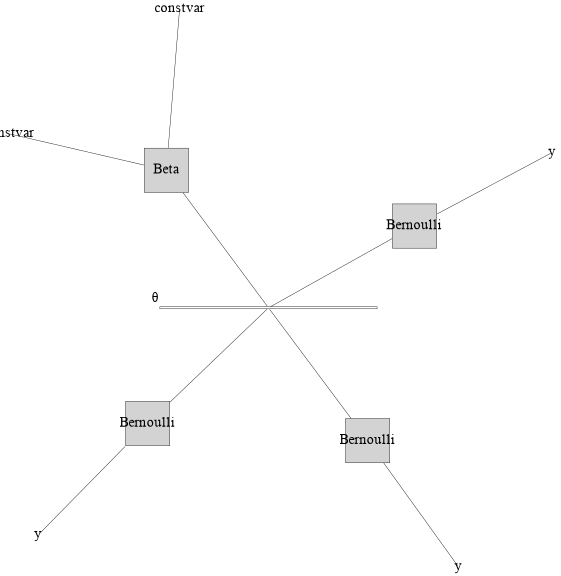

In [31]:
# execute the DOT code string
show_gv(coin_toss_dot_ll)

In [92]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(coin_toss_dot_ll, "coin_toss_viz/coin_toss_dot_ll_pdf_render.pdf")

# Example 2 - Linear Regression Model:

### Linear Regression Model - Existing Functionality:

In [57]:
Graphs.is_cyclic(linr_meta_graph)

true

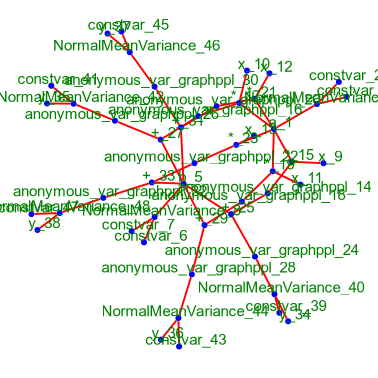

In [47]:
# The existing plotting functionality:
GraphPlot.gplot(
    linr_meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(linr_meta_graph)),
    nodelabelsize=0.1,
    NODESIZE=0.02, # diameter of the nodes,
    nodelabelc="green",
    nodelabeldist=3.0,
    nodefillc="blue",
    edgestrokec="red",
    EDGELINEWIDTH = 0.5
)

In [93]:
# render the meta_graph and save render to a pdf:
meta_graph_to_pdf("linr_reg_viz/linr_reg_GraphPlot.pdf", linr_meta_graph)

### Linear Regression Model - Vanilla generate_dot:

In [51]:
# create the DOT code string
linr_model_dot = generate_dot(
    Model = linr_gppl_model,
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

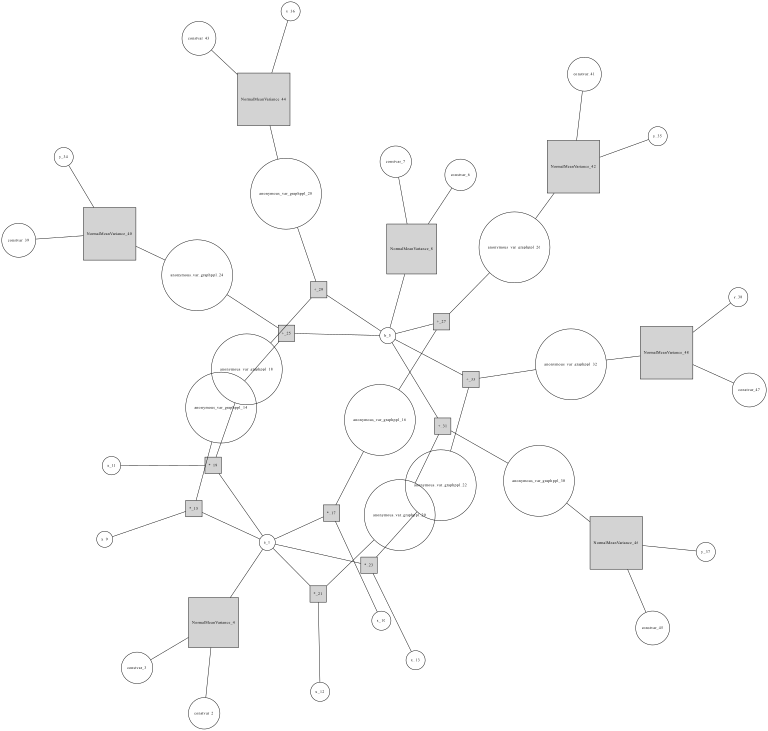

In [52]:
# execute the DOT code string
show_gv(linr_model_dot)

In [95]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(linr_model_dot, "linr_reg_viz/linr_model_pdf_render.pdf")

### Linear Regression Model - BFS generate_dot:

In [53]:
# create the DOT code string
linr_model_dot_BFS, parents = generate_dot_BFS(
    Model = linr_gppl_model,
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

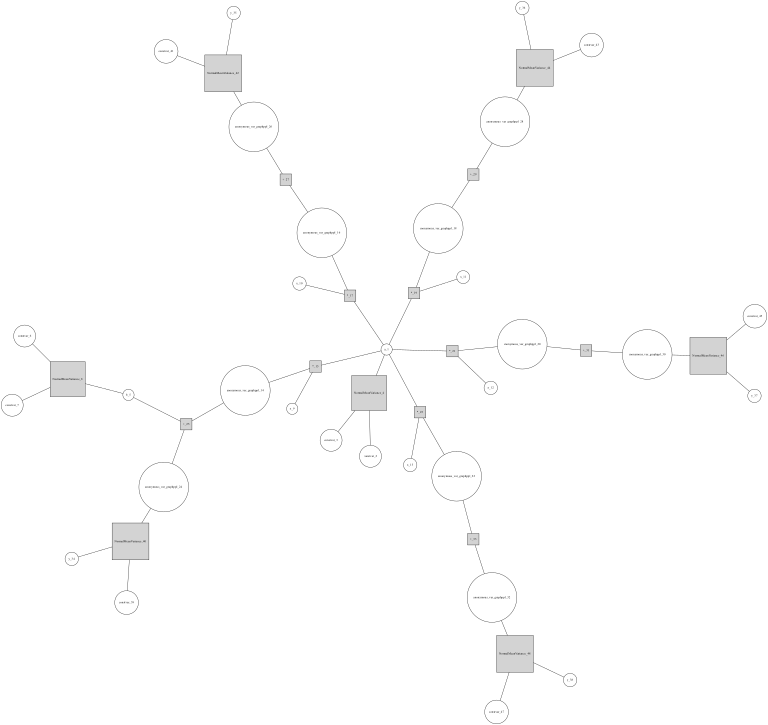

In [54]:
# execute the DOT code string
show_gv(linr_model_dot_BFS)

In [96]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(linr_model_dot_BFS, "linr_reg_viz/linr_model_BFS_pdf_render.pdf")

### Linear Regression Model - generate_dot learnableloop.com:

In [55]:
# create the DOT code string
linr_model_dot_ll = generate_dot_ll(
    Model = linr_gppl_model,
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

In [56]:
# execute the DOT code string
show_gv(linr_model_dot_ll)

Error: syntax error in line 540 near ','


GraphViz.Graph(Ptr{Nothing} @0x0000000000000000, false)

# Example 3 - Hidden Markov Model with Control:

### Hidden Markov Model with Control - Existing Functionality:

In [105]:
Graphs.is_cyclic(hmm_meta_graph)

true

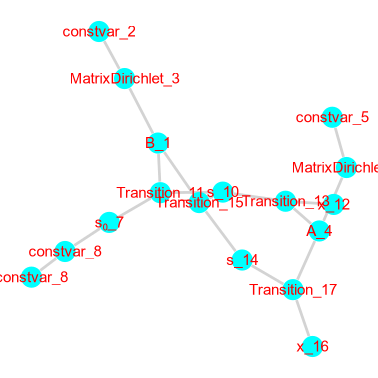


(process:110860): Pango-WARNING **: 16:39:49.955: pango_layout_set_markup_with_accel: Error on line 1 char 41: “:Real_9<” is not a valid name: “<”


In [107]:
GraphPlot.gplot( ## existing plotting functionality
    hmm_meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(hmm_meta_graph)),
    nodelabelsize=1.0,
    NODESIZE=0.07, ## diameter of the nodes
    nodelabelc="red", #.
    nodelabeldist=0.0,
    nodefillc="cyan",
)


In [108]:
# render the meta_graph and save render to a pdf:
meta_graph_to_pdf("hmm_viz/hmm_model_GraphPlot.pdf", hmm_meta_graph)


(process:110860): Pango-WARNING **: 16:39:55.821: pango_layout_set_markup_with_accel: Error on line 1 char 41: “:Real_9<” is not a valid name: “<”


### Hidden Markov Model with Control - Vanilla generate_dot:

In [109]:
# create the DOT code string
hmm_model_dot = generate_dot(
    Model = hmm_gppl_model,
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

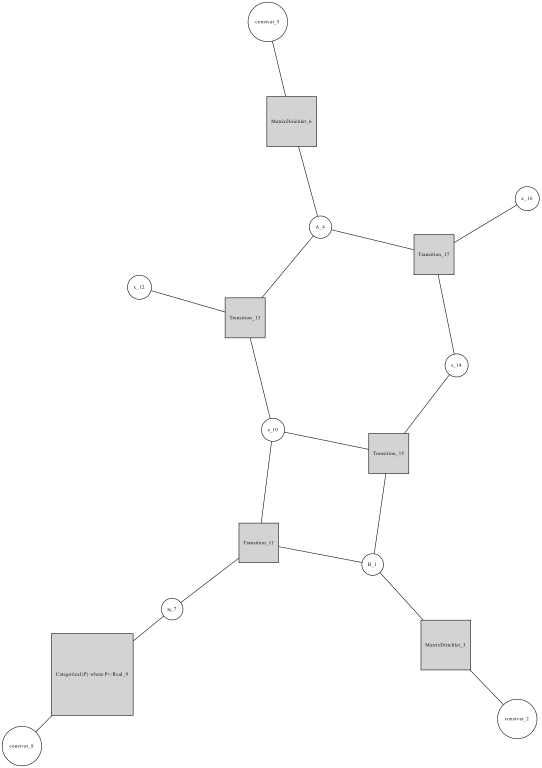

In [110]:
# execute the DOT code string
show_gv(hmm_model_dot)

In [111]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(hmm_model_dot, "hmm_viz/hmm_model_pdf_render.pdf")

### Hidden Markov Model with Control - BFS generate_dot:

In [112]:
# create the DOT code string
hmm_model_dot_BFS, parents = generate_dot_BFS(
    Model = hmm_gppl_model,
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

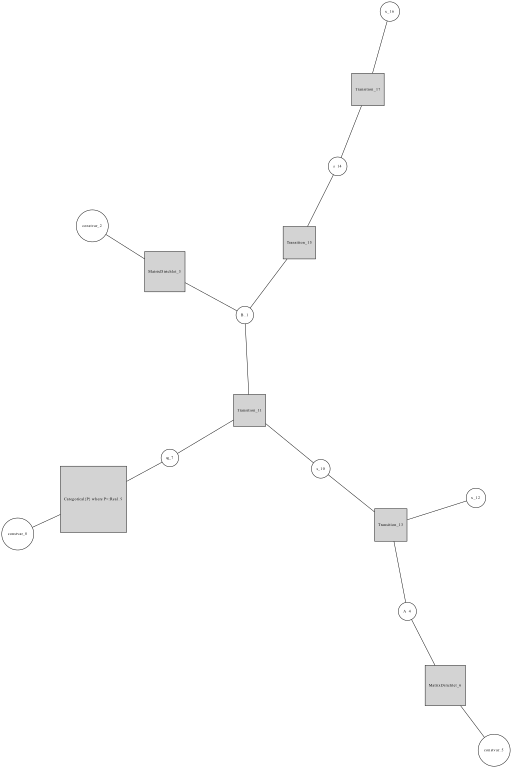

In [113]:
# execute the DOT code string
show_gv(hmm_model_dot_BFS)

In [114]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(hmm_model_dot_BFS, "hmm_viz/hmm_model_BFS_pdf_render.pdf")

### Hidden Markov Model with Control - generate_dot learnableloop.com:

In [115]:
# create the DOT code string
hmm_model_dot_ll = generate_dot_ll(
    Model = hmm_gppl_model,
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

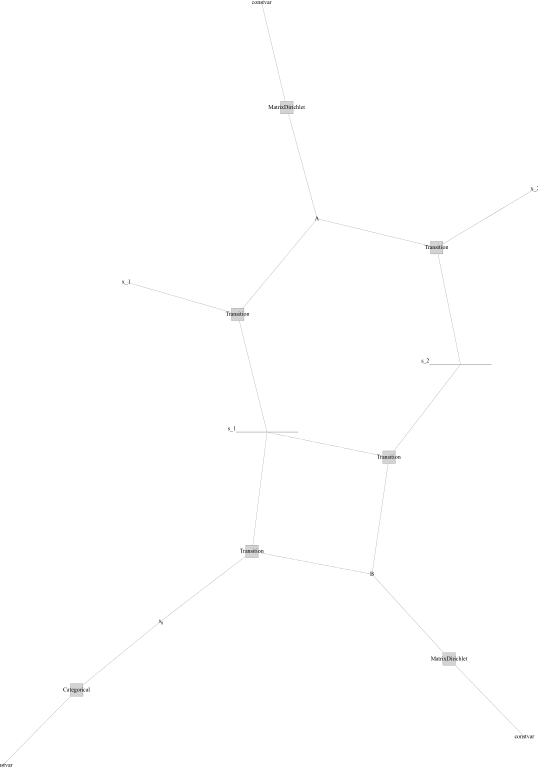

In [116]:
# execute the DOT code string
show_gv(hmm_model_dot_ll)

In [117]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(hmm_model_dot_ll, "hmm_viz/hmm_model_dot_ll_pdf_render.pdf")

# Example 4 - Time-Varying Autoregressive Model:

### Autoregressive Model - Existing Functionality:

In [130]:
Graphs.is_cyclic(lar_meta_graph)

true

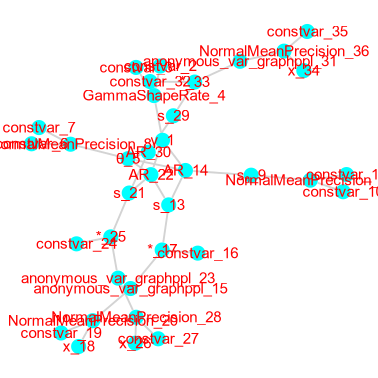

In [124]:
GraphPlot.gplot( ## existing plotting functionality
    lar_meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(lar_meta_graph)),
    nodelabelsize=1.0,
    NODESIZE=0.05, ## diameter of the nodes
    nodelabelc="red", #.
    nodelabeldist=0.0,
    nodefillc="cyan",
)

In [126]:
# render the meta_graph and save render to a pdf:
meta_graph_to_pdf("lar_viz/lar_model_GraphPlot.pdf", lar_meta_graph)

### Autoregressive Model - Vanilla generate_dot:

In [127]:
# create the DOT code string
lar_model_dot = generate_dot(
    Model = lar_gppl_model,
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

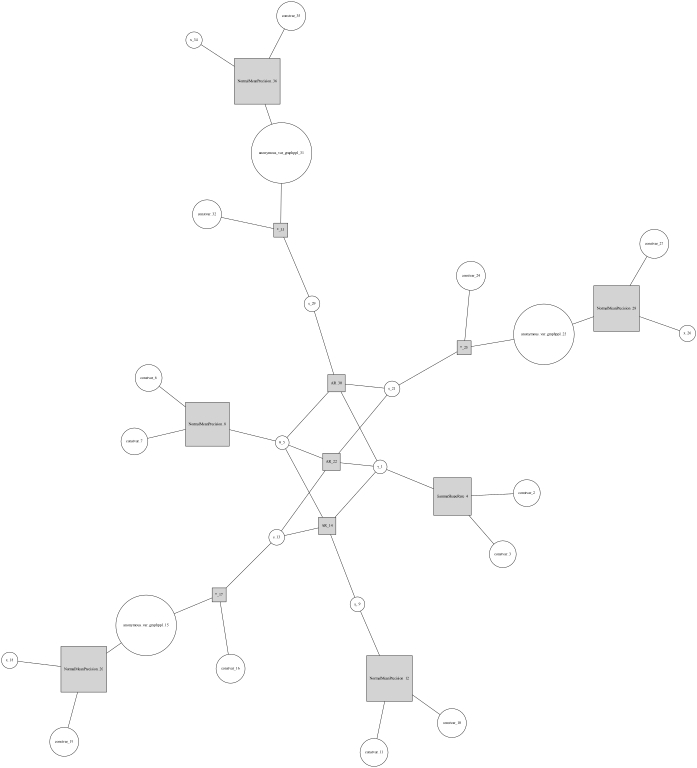

In [128]:
# execute the DOT code string
show_gv(lar_model_dot)

In [129]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(lar_model_dot, "lar_viz/lar_model_pdf_render.pdf")

### Autoregressive Model - BFS generate_dot:

In [131]:
# create the DOT code string
lar_model_dot_BFS, parents = generate_dot_BFS(
    Model = lar_gppl_model,
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

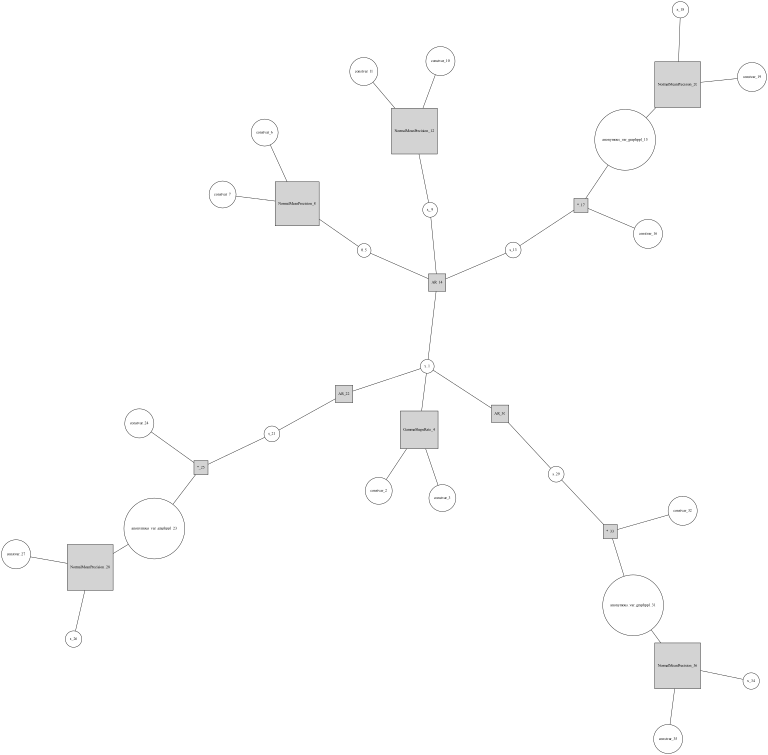

In [133]:
# execute the DOT code string
show_gv(lar_model_dot_BFS)

In [134]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(lar_model_dot_BFS, "lar_viz/lar_model_BFS_pdf_render.pdf.pdf")

### Autoregressive Model - generate_dot learnableloop.com:

In [135]:
# create the DOT code string
lar_model_dot_ll = generate_dot_ll(
    Model = lar_gppl_model,
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

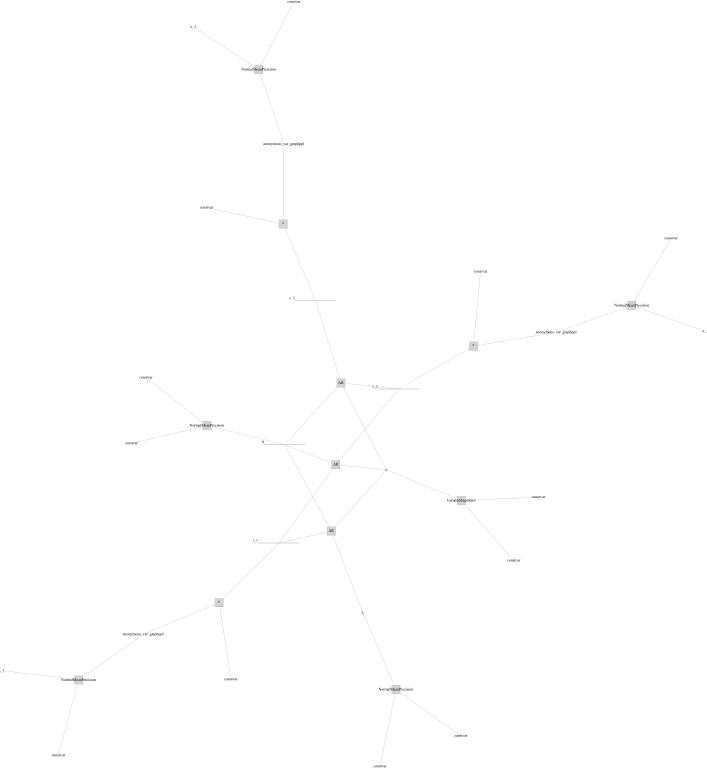

In [136]:
# execute the DOT code string
show_gv(lar_model_dot_ll)

In [137]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(lar_model_dot_ll, "lar_viz/lar_model_dot_ll_pdf_render.pdf")

# Querying The Structure of The Graph

## Contexts

After creating a GraphPPL.Model structure, it is important to know about the attached Context. The Context structure contains all variable and factor nodes in the scope of the model, and contains a Context stucture for all submodels. The context of a model can be accessed by the ```GraphPPL.getcontext()``` function:

In [10]:
fieldnames(GraphPPL.Context)

(:depth, :fform, :prefix, :parent, :submodel_counts, :children, :factor_nodes, :individual_variables, :vector_variables, :tensor_variables, :proxies, :returnval)

In [11]:
gppl_model_context = GraphPPL.getcontext(gppl_model)

Context()
 Individual variables: {:constvar_2, :θ, :constvar_3}
 Vector variables: {:y}
 Tensor variables: {}
 Proxies: {}
 Factor nodes: GraphPPL.FactorID[(Beta, 1), (Bernoulli, 2), (Bernoulli, 1), (Bernoulli, 3)]


In [12]:
function gppl_global_context_info(model::GraphPPL.Model)
    
    context = GraphPPL.getcontext(model)
    
    println("Individual variables: ", context.individual_variables)
    println("Vector variables: ", context.vector_variables)
    println("Tensor variables: ", context.tensor_variables)
    println("Proxies: ", context.proxies)
    println("Factor nodes: ", context.factor_nodes)
    println("Depth: ", context.depth)
    println("Prefix: ", context.prefix)
    println("Parent: ", context.parent)
    println("Submodel counts: ", context.submodel_counts)
    println("Children: ", context.children)
    println("Returnval: ", context.returnval)
    println("------------------------------------- Factor Nodes -------------------------------------")
    
    for factor_node in context.factor_nodes
        node_data = model[factor_node]
        println("Factor Node: ", factor_node)
        println("  Form: ", node_data.properties.fform)
        println("  Neighbors:")
        for (label, edge, neighbor) in node_data.properties.neighbors
            println("    - Label: ", label)
            println("      Edge: ", edge)
            println("      Neighbor: ", neighbor)
            println("      Type of Neighbor: ", typeof(neighbor))
            println()
        end
    end
end

gppl_global_context_info (generic function with 1 method)

In [13]:
gppl_global_context_info(gppl_model)

Individual variables: {:constvar_2 = constvar_2, :θ = θ_1, :constvar_3 = constvar_3}
Vector variables: {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_5, y_7, y_9])}
Tensor variables: {}
Proxies: {}
Factor nodes: {(Beta, 1) = Beta_4, (Bernoulli, 2) = Bernoulli_8, (Bernoulli, 1) = Bernoulli_6, (Bernoulli, 3) = Bernoulli_10}
Depth: 0
Prefix: 
Parent: nothing
Submodel counts: {Beta = 1, Bernoulli = 3}
Children: {}
Returnval: Base.RefValue{Any}(nothing)
------------------------------------- Factor Nodes -------------------------------------
Factor Node: Beta_4
  Form: Beta
  Neighbors:
    - Label: θ_1
      Edge: out
      Neighbor: NodeData in context  with properties name = θ, index = nothing
      Type of Neighbor: GraphPPL.NodeData

    - Label: constvar_2
      Edge: a
      Neighbor: NodeData in context  with properties name = constvar, index = nothing
      Type of Neighbor: GraphPPL.NodeData

    - Label: constvar_3
      Edge: b
      Neighbor: NodeData in context

In [106]:
source = 1
bfs_tree_graph = bfs_tree(linr_gppl_model.graph, source)

{48, 47} directed simple Int64 graph

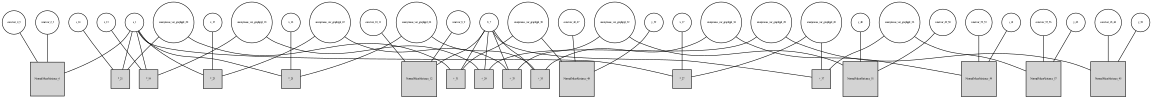

In [199]:
# Use a different graphViz layout engine: "dot"
linr_model_dot_2 = generate_dot(
    Model = linr_gppl_model,
    font_size = 5,
    edge_length = 2.5,
    layout = "dot",
    width = 12.0,
    height = 12.0
);

# execute the DOT code string
show_gv(linr_model_dot_2)

# Experimentation with Other Features (Highy Disorganised):

# Tikz/PGF

In [23]:
preamble = """\\documentclass{standalone}
\\usepackage{tikz}
\\usetikzlibrary{graphs,graphdrawing,quotes}
\\usegdlibrary{force}

\\begin{document}
\\begin{tikzpicture}
  \\graph [spring layout, node distance=20mm,
 nodes={draw, circle, fill=blue, text=white},
  edge quotes={fill=yellow, inner sep=2pt}]
  {\n"""

postamble = """};
\\end{tikzpicture}
\\end{document}"""

G = meta_graph

tex_code = preamble

for vertex in MetaGraphsNext.vertices(G)
    tex_code *= "    $(vertex) [as={\$n_{$(vertex)}\$}];\n"
end

for edge in MetaGraphsNext.edges(G)
    source_vertex = MetaGraphsNext.label_for(G, edge.src)
    dest_vertex = MetaGraphsNext.label_for(G, edge.dst)
    tex_code *= "    $(source_vertex) -- $(dest_vertex);\n"
end

tex_code *= postamble

# Write the TikZ code to a .tex file
file_path = "tikz_graph.tex"
open(file_path, "w") do file
    write(file, tex_code)
end

772

In [54]:
for edge in MetaGraphsNext.edges(meta_graph)
    println("$(edge.src)")
    println("$(MetaGraphsNext.label_for(meta_graph, edge.src))\n")
#     dot_code *= "    $(edge.src) -> $(edge.dst);"
end

1
θ_1

1
θ_1

1
θ_1

1
θ_1

2
constvar_2_3

3
constvar_4_5

5
y_7

7
y_9

9
y_11



In [55]:
for edge in MetaGraphsNext.edges(meta_graph)
    println("$(edge.dst)")
    println("$(MetaGraphsNext.label_for(meta_graph, edge.src))\n")
#     dot_code *= "    $(edge.src) -> $(edge.dst);"
end

4
Beta_6

6
Bernoulli_8

8
Bernoulli_10

10
Bernoulli_12

4
Beta_6

4
Beta_6

6
Bernoulli_8

8
Bernoulli_10

10
Bernoulli_12



In [27]:
typeof(MetaGraphsNext.edges(meta_graph))

Graphs.SimpleGraphs.SimpleEdgeIter{Graphs.SimpleGraphs.SimpleGraph{Int64}}

In [33]:
MetaGraphsNext.label_for(meta_graph, 1)

GraphPPL.NodeLabel

In [39]:
for i in 1:length(collect(labels(meta_graph)))
    println(MetaGraphsNext.label_for(meta_graph, i))
end

θ_1
constvar_2_3
constvar_4_5
Beta_6
y_7
Bernoulli_8
y_9
Bernoulli_10
y_11
Bernoulli_12


In [40]:
collect(labels(meta_graph))

10-element Vector{GraphPPL.NodeLabel}:
 θ_1
 constvar_2_3
 constvar_4_5
 Beta_6
 y_7
 Bernoulli_8
 y_9
 Bernoulli_10
 y_11
 Bernoulli_12

In [30]:
# for node in BFSIterator(gppl_model, 1)
#     println(node)
# end

In [83]:
# Perform BFS and get the BFS tree
source = 1
bfs_tree_graph = bfs_tree(meta_graph.graph, source)
bfs_parents_arr = bfs_parents(meta_graph.graph, source) # bfs_parents_arr[i] = parent of node i

10-element Vector{Int64}:
  1
  4
  4
  1
  6
  1
  8
  1
 10
  1

In [54]:
typeof(bfs_tree_graph)

SimpleDiGraph{Int64}

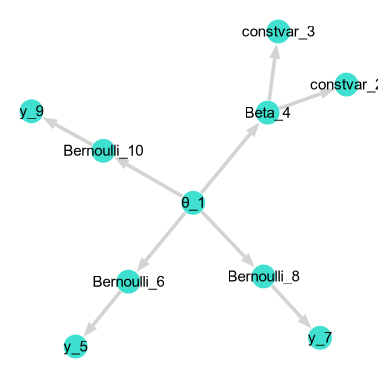

In [74]:
GraphPlot.gplot(
    bfs_tree_graph,
    nodelabel=collect(labels(meta_graph))
)

In [40]:
MetaGraphsNext.neighbors(meta_graph, 1)

4-element Vector{Int64}:
  4
  6
  8
 10

In [76]:
typeof(bfs_tree_graph)

SimpleDiGraph{Int64}

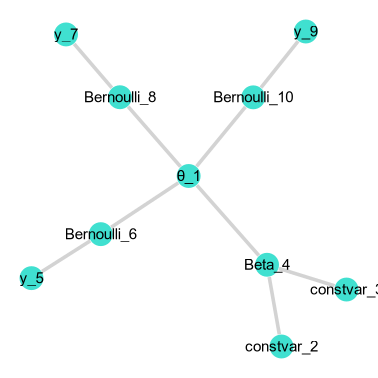

In [65]:
GraphPlot.gplot(
    meta_graph.graph,
    nodelabel=collect(labels(meta_graph))
)

In [72]:
meta_graph

Meta graph based on a SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Beta = 1, Bernoulli = 3}, {}, {(Beta, 1) = Beta_4, (Bernoulli, 2) = Bernoulli_8, (Bernoulli, 1) = Bernoulli_6, (Bernoulli, 3) = Bernoulli_10}, {:constvar_2 = constvar_2, :θ = θ_1, :constvar_3 = constvar_3}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_5, y_7, y_9])}, {}, {}, Base.RefValue{Any}(nothing)), and default weight 1.0

In [85]:
GraphPPL.MetaGraphsNext.label_for(meta_graph, bfs_parents_arr[1])

θ_1

In [86]:
GraphPPL.MetaGraphsNext.label_for(meta_graph, 1)

θ_1

In [90]:
for i in 1:nv(meta_graph)
    println(GraphPPL.MetaGraphsNext.label_for(meta_graph, i))
end

θ_1
constvar_2
constvar_3
Beta_4
y_5
Bernoulli_6
y_7
Bernoulli_8
y_9
Bernoulli_10


In [91]:
for i in 1:nv(meta_graph)
    println(GraphPPL.MetaGraphsNext.label_for(meta_graph, bfs_parents_arr[i]))
end

θ_1
Beta_4
Beta_4
θ_1
Bernoulli_6
θ_1
Bernoulli_8
θ_1
Bernoulli_10
θ_1


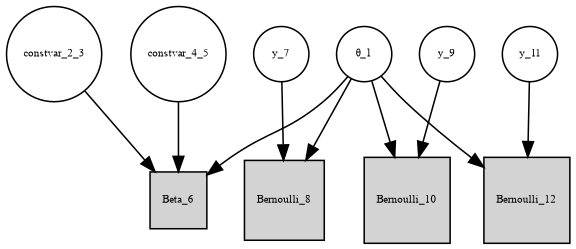

In [26]:
dot"""
digraph G {
    layout=dot;
    size="6.0,6.0!";
    node [shape=circle, fontsize=7];

    // Define root node
    "θ_1" [shape=circle];

    // Other nodes
    "constvar_2_3" [shape=circle];
    "constvar_4_5" [shape=circle];
    "Beta_6" [shape=square, style=filled, fillcolor=lightgray];
    "y_7" [shape=circle];
    "Bernoulli_8" [shape=square, style=filled, fillcolor=lightgray];
    "y_9" [shape=circle];
    "Bernoulli_10" [shape=square, style=filled, fillcolor=lightgray];
    "y_11" [shape=circle];
    "Bernoulli_12" [shape=square, style=filled, fillcolor=lightgray];

    // Define edges
    "θ_1" -> "Beta_6";
    "θ_1" -> "Bernoulli_8";
    "θ_1" -> "Bernoulli_10";
    "θ_1" -> "Bernoulli_12";
    "constvar_2_3" -> "Beta_6";
    "constvar_4_5" -> "Beta_6";
    "y_7" -> "Bernoulli_8";
    "y_9" -> "Bernoulli_10";
    "y_11" -> "Bernoulli_12";

    // Ensure "θ_1" is the root node
    { rank = min; "θ_1"; }

    // Define ranks to ensure top-down hierarchy
    { rank = same; "Beta_6"; "Bernoulli_8"; "Bernoulli_10"; "Bernoulli_12"; }
    { rank = same; "constvar_2_3"; "constvar_4_5"; "y_7"; "y_9"; "y_11"; }
}
"""

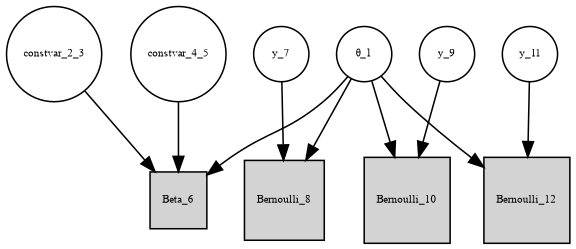

In [23]:
dot"""
digraph G {
    layout=dot;  // Use dot layout for hierarchical structure
    size="6.0,6.0!";
    node [shape=circle, fontsize=7];
    
    // Define root node
    "θ_1" [shape=circle];
    
    // Other nodes
    "constvar_2_3" [shape=circle];
    "constvar_4_5" [shape=circle];
    "Beta_6" [shape=square, style=filled, fillcolor=lightgray];
    "y_7" [shape=circle];
    "Bernoulli_8" [shape=square, style=filled, fillcolor=lightgray];
    "y_9" [shape=circle];
    "Bernoulli_10" [shape=square, style=filled, fillcolor=lightgray];
    "y_11" [shape=circle];
    "Bernoulli_12" [shape=square, style=filled, fillcolor=lightgray];
    
    // Define edges
    "θ_1" -> "Beta_6" [len=1.0];
    "θ_1" -> "Bernoulli_8" [len=1.0];
    "θ_1" -> "Bernoulli_10" [len=1.0];
    "θ_1" -> "Bernoulli_12" [len=1.0];
    "constvar_2_3" -> "Beta_6" [len=1.0];
    "constvar_4_5" -> "Beta_6" [len=1.0];
    "y_7" -> "Bernoulli_8" [len=1.0];
    "y_9" -> "Bernoulli_10" [len=1.0];
    "y_11" -> "Bernoulli_12" [len=1.0];

    // Ensure "θ_1" is the root node
    { rank = min; "θ_1"; }

    // Define ranks to ensure top-down hierarchy
    { rank = same; "constvar_2_3"; "constvar_4_5"; }
    { rank = same; "Beta_6"; "Bernoulli_8"; "Bernoulli_10"; "Bernoulli_12"; }
    { rank = same; "y_7"; "y_9"; "y_11"; }
}
"""

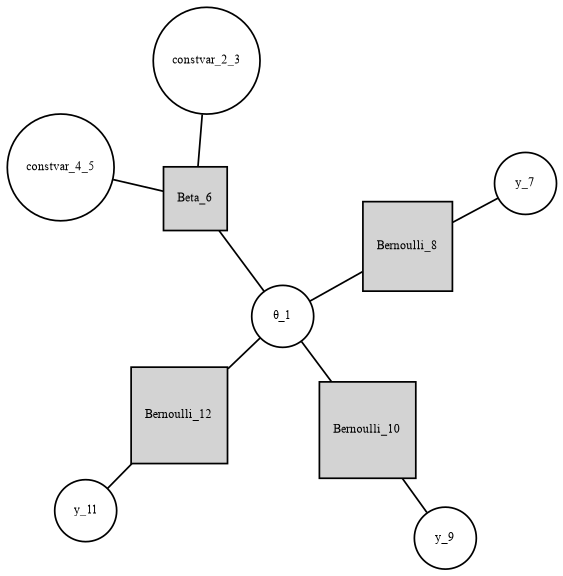

In [18]:
# this is the above DOT for the coin-toss model
dot"""
graph G {
    layout=neato;
    size="6.0,6.0!";
    node [shape=circle, fontsize=7];
    "θ_1" [shape=circle];
    "constvar_2_3" [shape=circle];
    "constvar_4_5" [shape=circle];
    "Beta_6" [shape=square, style=filled, fillcolor=lightgray];
    "y_7" [shape=circle];
    "Bernoulli_8" [shape=square, style=filled, fillcolor=lightgray];
    "y_9" [shape=circle];
    "Bernoulli_10" [shape=square, style=filled, fillcolor=lightgray];
    "y_11" [shape=circle];
    "Bernoulli_12" [shape=square, style=filled, fillcolor=lightgray];
    "θ_1" -- "Beta_6" [len=1.0];
    "θ_1" -- "Bernoulli_8" [len=1.0];
    "θ_1" -- "Bernoulli_10" [len=1.0];
    "θ_1" -- "Bernoulli_12" [len=1.0];
    "constvar_2_3" -- "Beta_6" [len=1.0];
    "constvar_4_5" -- "Beta_6" [len=1.0];
    "y_7" -- "Bernoulli_8" [len=1.0];
    "y_9" -- "Bernoulli_10" [len=1.0];
    "y_11" -- "Bernoulli_12" [len=1.0];
}
"""

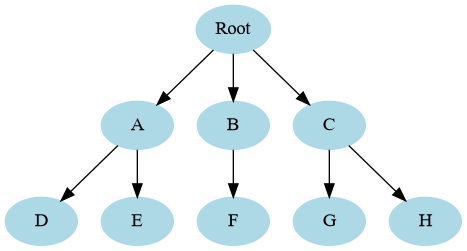

In [14]:
dot"""
digraph Tree {
    // Set the layout engine to dot
    layout = dot;

    // Graph attributes
    rankdir = TB;  // Top to Bottom layout

    // Define nodes
    node [shape = ellipse, style=filled, color=lightblue];  // Example node style

    // Define the edges to represent the tree structure
    Root -> A;
    Root -> B;
    Root -> C;
    A -> D;
    A -> E;
    B -> F;
    C -> G;
    C -> H;

    // Optional: Define subgraphs to force specific nodes to be on the same level
    {
        rank = same; A; B; C;
    }
    {
        rank = same; D; E; F; G; H;
    }
}
"""

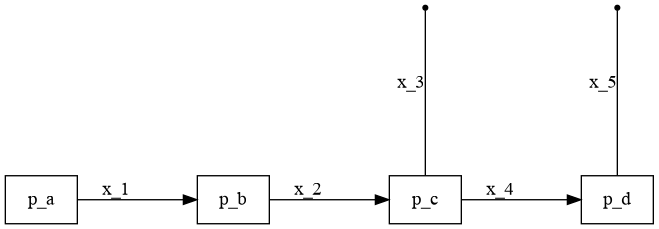

In [39]:
dot"""
digraph ForneyFactorGraph {
    // Nodes (factors) with custom positions
    pa [label="p_a", shape=box, pos="0,0!"];
    pb [label="p_b", shape=box, pos="2,0!"];
    pc [label="p_c", shape=box, pos="4,0!"];
    pd [label="p_d", shape=box, pos="6,0!"];

    // Edges (variables)
    pa -> pb [label="x_1", len=2.0];
    pb -> pc [label="x_2", len=2.0];
    pc -> x3 [label="x_3", arrowhead=none, len=2.0];
    pd -> x5 [label="x_5", arrowhead=none, len=2.0];
    pc -> pd [label="x_4", len=2.0];

    // Invisible nodes for half-edges
    x3 [shape=point, pos="4,2!"];
    x5 [shape=point, pos="6,2!"];

    // Set layout style
    layout = "neato";
}
"""

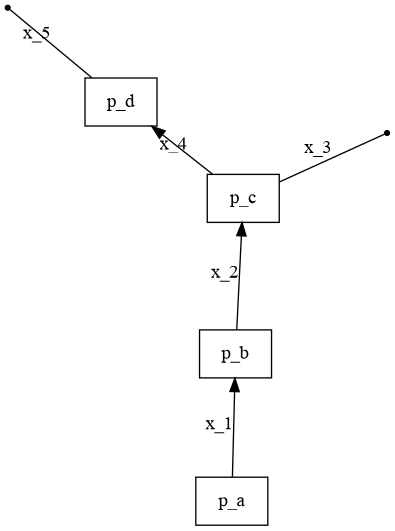

In [21]:
dot"""
digraph ForneyFactorGraph {
    // Nodes (factors)
    pa [label="p_a", shape=box];
    pb [label="p_b", shape=box];
    pc [label="p_c", shape=box];
    pd [label="p_d", shape=box];

    // Edges (variables)
    pa -> pb [label="x_1", len=1.5];
    pb -> pc [label="x_2", len=1.5];
    pc -> x3 [label="x_3", arrowhead=none, len=1.5];
    pd -> x5 [label="x_5", arrowhead=none, len=1.5];
    pc -> pd [label="x_4", len=1.5];

    // Invisible nodes for half-edges
    x3 [shape=point];
    x5 [shape=point];
    
    // Set layout style
    layout = "neato";
}
"""

## Nodes with Internal Structure

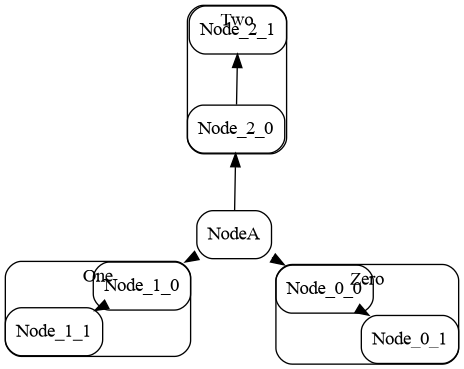

In [44]:
dot"""
digraph G {
  compound=true;
  node [ shape = "Mrecord" ];
  subgraph cluster_0 {
    style = rounded;
    label = "Zero";
	Node_0_0 -> Node_0_1;
  };
  subgraph cluster_1 {
    style = rounded;
    label = "One";
 	Node_1_0 -> Node_1_1;
  };
  subgraph cluster_2 {
    style = rounded;
    label = "Two";
    Node_2_0 -> Node_2_1;
  };
  NodeA [ style = rounded ];
  NodeA -> Node_0_0 [lhead = cluster_0];
  NodeA -> Node_1_0 [lhead = cluster_1];
  NodeA -> Node_2_0 [lhead = cluster_2];
}
"""

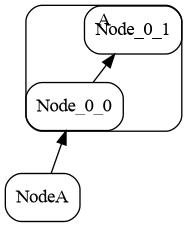

In [46]:
dot"""
digraph G {
  compound=true;
  node [ shape = "Mrecord" ];

  subgraph cluster_0 {
    style = rounded;
    label = "A";
	Node_0_0 -> Node_0_1;
  };

  NodeA [ style = rounded ];
  NodeA -> Node_0_0 [lhead = cluster_0];
}
"""

In [44]:
for vertex in MetaGraphsNext.vertices(meta_graph)  # add nodes
    println(MetaGraphsNext.label_for(meta_graph, vertex))
end

θ_1
constvar_2_3
constvar_4_5
Beta_6
y_7
Bernoulli_8
y_9
Bernoulli_10
y_11
Bernoulli_12


# Old Functionality (String Concat)

In [151]:
"""
A helper function to wrap GraphViz DOT code in the 
command string used with GraphViz.jl 
"""
function wrap_dot_code(dot_code::String)
    return "dot\"\"\"\n$dot_code\n\"\"\""
end

wrap_dot_code

In [169]:
"""
Basic visualisation of a GraphPPL.Model with GraphViz.
Isomorphic to the display given by GraphPlot.gplot.
"""
function show_gv_V2(; Model::GraphPPL.Model, font_size::Int, edge_length::Float64 = 1.0)
    
    meta_graph = Model.graph # underlying MetaGraphsNext graph
    
    
    dot_code = """
    graph G {
        node [shape=circle, fontsize=$(font_size)];
    """
    
    # Vertices/Nodes
    for vertex in MetaGraphsNext.vertices(meta_graph)
        label = MetaGraphsNext.label_for(meta_graph, vertex)
        
        properties = Model[label].properties # for dsistnguishing factor/variable nodes
        
        if isa(properties, GraphPPL.FactorNodeProperties) # Factor node
            dot_code *= "    \"$(label)\" [shape=square, style=filled, fillcolor=lightgray];\n"
        elseif isa(properties, GraphPPL.VariableNodeProperties) # Variable Node
            dot_code *= "    \"$(label)\" [shape=circle];\n"
        else
            println("ERROR: Unknown node type for label $(label)")
        end
    end
    
    # Edges
    for edge in MetaGraphsNext.edges(meta_graph)
        source_vertex = MetaGraphsNext.label_for(meta_graph, edge.src)
        dest_vertex = MetaGraphsNext.label_for(meta_graph, edge.dst)
        dot_code *= "    \"$(source_vertex)\" -- \"$(dest_vertex)\" [len=$(edge_length)];\n"
    end
    
    dot_code *= "}"

    wrapped_dot_code = wrap_dot_code(dot_code)
    
    eval(Meta.parse(wrapped_dot_code)) # not ideal, but used for this example
end

show_gv_V2

In [170]:
"""
Basic visualisation a GraphPPL.Model with GraphViz.
Isomorphic to the display given by GraphPlot.gplot.
"""
function show_gv_OG(; Model::GraphPPL.Model, font_size::Int)
    
    meta_graph = Model.graph # underlying MetaGraphsNext graph
    
    dot_code = """
    graph G {
        node [shape=circle, fontsize=$(font_size)];
    """

#     for vertex in MetaGraphsNext.vertices(G)  # add nodes
#         dot_code *="    $(MetaGraphsNext.label_for(G, vertex));\n"
#     end
    
    for vertex in MetaGraphsNext.vertices(meta_graph)
        label = MetaGraphsNext.label_for(meta_graph, vertex)
        if isa(Model[label].properties, GraphPPL.FactorNodeProperties{GraphPPL.NodeData})
            dot_code *="    $(MetaGraphsNext.label_for(meta_graph, vertex)) [shape=square];\n"
        elseif isa(Model[label].properties, GraphPPL.VariableNodeProperties{GraphPPL.NodeData})
            dot_code *="    $(MetaGraphsNext.label_for(meta_graph, vertex)) [shape=circle];\n"
        else
            println("ERROR")
        end
    end
    
#     for (factor_id, node_label) in pairs(gppl_model_context.factor_nodes)
#         # get vertex code from the meta graph
#         # test if this vertex code belongs to a node factor 
#         #     if yes, make this node's shape square
#         println("TESTING")
#     end

    for edge in MetaGraphsNext.edges(meta_graph)  # add edges
        source_vertex = MetaGraphsNext.label_for(meta_graph, edge.src)
        dest_vertex = MetaGraphsNext.label_for(meta_graph, edge.dst)
        dot_code *= "    $(source_vertex) -- $(dest_vertex);\n"
    end
    
    dot_code *= "}"

    wrapped_dot_code = wrap_dot_code(dot_code)
    
    eval(Meta.parse(wrapped_dot_code)) # not ideal 

end

show_gv_OG